# Centralizing the Data Vizualizations from the Paper

In [1]:
#path configuration
to_data_parent = "../Data/abby_ceo" #path to the parent folder, should contain program subfolders
to_data_folder = "../Data" #data folder, where composite data was written from the TSDC_data file

In [2]:
# dependencies
from collections import defaultdict

from paper_utilities import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

params = {'legend.fontsize': 'small',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)

import importlib

## full data - for labeling rates

In [3]:
#gather all of the trips into one dataframe
#loop over
programs = ['4c', 'cc', 'fc', 'pc', 'sc', 'vail_22']
datasets = []

for program in programs:
    print('starting with ', program)
    
    #create dataset with surveys and trips
    trips = pd.read_csv(to_data_parent + '/' + program + '/analysis_confirmed_trip.csv')
    print(len(trips), 'trips')
    print(trips.perno.nunique(), 'people')

    #prepare trip ids for merging
    trips['user_id_socio'] = trips.perno.astype(str)
    trips['user_id_socio'] = trips['user_id_socio'].str.strip() #remove leading or trailing whitespace!!
    trips.user_id_socio = [i.replace('-','') for i in trips.user_id_socio] # remove all dashes from strings
    
    trips['program'] = program.split('_')[0]
    
    #add to list of datasets
    datasets.append(trips)

participant_ct_df = pd.concat(datasets)

#just labeled data
labeled_df = participant_ct_df[participant_ct_df.data_user_input_mode_confirm.notna() | 
                                       participant_ct_df.data_user_input_purpose_confirm.notna() |
                                       participant_ct_df.data_user_input_replaced_mode.notna()]

starting with  4c
14424 trips
15 people
starting with  cc
75199 trips
52 people
starting with  fc
32442 trips
30 people
starting with  pc
51196 trips
39 people
starting with  sc
17989 trips
22 people
starting with  vail_22
9133 trips
12 people


In [4]:
all_user_trips = participant_ct_df.groupby(['user_id_socio'], as_index=False).count()[['user_id_socio','data_distance']]
print(len(all_user_trips), "total users")

labeled_user_trips = labeled_df.groupby(['user_id_socio'], as_index=False).count()[['user_id_socio','data_distance']]
print(len(labeled_user_trips), "users who labeled")

plot_data = all_user_trips.merge(labeled_user_trips, how='right', on='user_id_socio').fillna(0)
plot_data.head()

170 total users
164 users who labeled


user_id_socio  data_distance_x  data_distance_y
0  0154d71439284c34b865e5a417cd48af             2104              276
1  03a395b4d8614757bb8432b4984559b0             1625              263
2  0958519bb4a64498b824015917eec592               18               17
3  0b3e78fa91d84aa6a3203440143c8c16             2430             2315
4  0d0ae3a556414d138c52a6040a203d24             1060                2

### figure 2

164


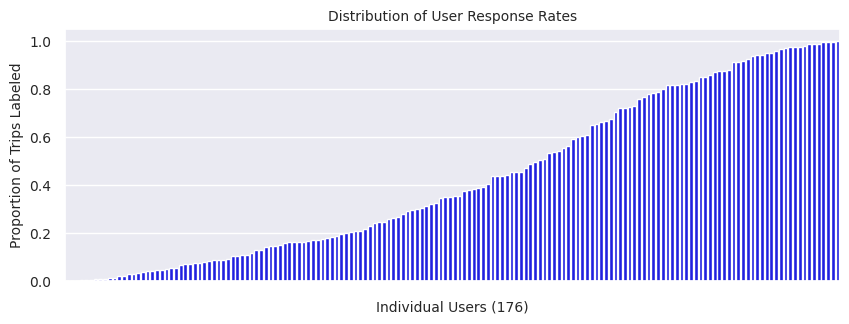

In [5]:
plot_data['proportion'] = plot_data['data_distance_y'] / plot_data['data_distance_x']
data_order = plot_data.sort_values('proportion', ascending=True).user_id_socio
print(len(plot_data))

plot_title='Distribution of User Response Rates'
ylab='Proportion of Trips Labeled'
file_name='CanBikeCO_report_user_participation%s'
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=plot_data, x='user_id_socio', y='proportion', order=data_order, color='blue').set(title=plot_title,xlabel='Individual Users (176)',ylabel=ylab,xticklabels=[])
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".jpg", bbox_inches='tight')

In [6]:
#drop infected data
all_data = participant_ct_df.copy()

all_data['data_start_local_dt_month'] = all_data['data_start_local_dt_month'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
all_data = all_data[all_data.data_start_local_dt_month >= 1]
all_data = all_data[all_data.data_start_local_dt_month <= 12]

all_data['data_start_local_dt_year'] = all_data['data_start_local_dt_year'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
all_data = all_data[all_data.data_start_local_dt_year >= 2019]
all_data = all_data[all_data.data_start_local_dt_year <= 2023]

labeled = labeled_df.copy()
labeled['data_start_local_dt_month'] = labeled['data_start_local_dt_month'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
labeled = labeled[labeled.data_start_local_dt_month >= 1]
labeled = labeled[labeled.data_start_local_dt_month <= 12]

labeled['data_start_local_dt_year'] = labeled['data_start_local_dt_year'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int).dropna()
labeled = labeled[labeled.data_start_local_dt_year >= 2019]
labeled = labeled[labeled.data_start_local_dt_year <= 2023]

In [7]:
#group the total data by day
all_data = (all_data.groupby(['data_start_local_dt_month', 'data_start_local_dt_year']).size() 
   .reset_index(name='count'))

all_data = all_data.sort_values(['data_start_local_dt_year', 'data_start_local_dt_month'])

all_data = all_data.astype({'data_start_local_dt_month': 'str'})
all_data = all_data.astype({'data_start_local_dt_year': 'str'})
all_data['Month'] = all_data[['data_start_local_dt_year', 'data_start_local_dt_month']].agg('-'.join, axis=1)

#group the labeled data by day#group the total data by day
labeled = (labeled.groupby(['data_start_local_dt_month', 'data_start_local_dt_year']).size() 
   .reset_index(name='count'))

labeled = labeled.sort_values(['data_start_local_dt_year', 'data_start_local_dt_month'])

labeled = labeled.astype({'data_start_local_dt_month': 'str'})
labeled = labeled.astype({'data_start_local_dt_year': 'str'})
labeled['Month'] = labeled[['data_start_local_dt_year', 'data_start_local_dt_month']].agg('-'.join, axis=1)

#merge them
plot_data = all_data.merge(labeled, how='left', on='Month').fillna(0)

#calc the proportion
plot_data['proportion'] = plot_data['count_y'] / plot_data['count_x']

#drop data before 6/2022 (when the full pilot started)
plot_data = plot_data.iloc[5:]

### figure 3

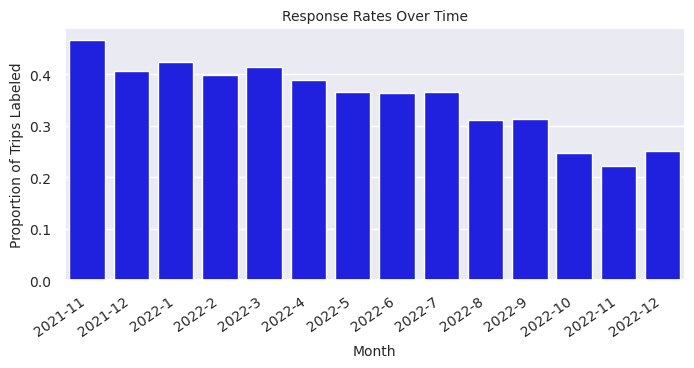

In [8]:
#graph it - bar chart
plot_title='Response Rates Over Time'
ylab='Proportion of Trips Labeled'
file_name='CanBikeCO_report_ts_labels'

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=plot_data, x='Month', y='proportion', color='blue').set(title=plot_title,xlabel='Month',ylabel=ylab)
plt.xticks(rotation=35, ha='right', fontsize=10)
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".jpeg", bbox_inches='tight')

## Loading from CSV way

In [9]:
# loading the data
cleaned_data = pd.read_csv(to_data_folder + "/tsdc_filtered_merged_trips.csv")

/tmp/ipykernel_2028/1677240394.py:2: DtypeWarning: Columns (3,77,84,87) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv(to_data_folder + "/tsdc_filtered_merged_trips.csv")


In [10]:
# Summary statistics table
print(len(pd.unique(cleaned_data.user_id)), "users in the cleaned data")
stat_data = cleaned_data[['distance','duration']]
stat_data.describe()

123 users in the cleaned data


distance      duration
count  61515.000000  61515.000000
mean    6343.428411     24.151089
std     9654.012933     30.701964
min      100.021226      0.000068
25%     1164.163633      9.174464
50%     3199.872213     15.292714
75%     7005.685132     28.075061
max    80444.735420    479.495935

## general demographics

figure #10

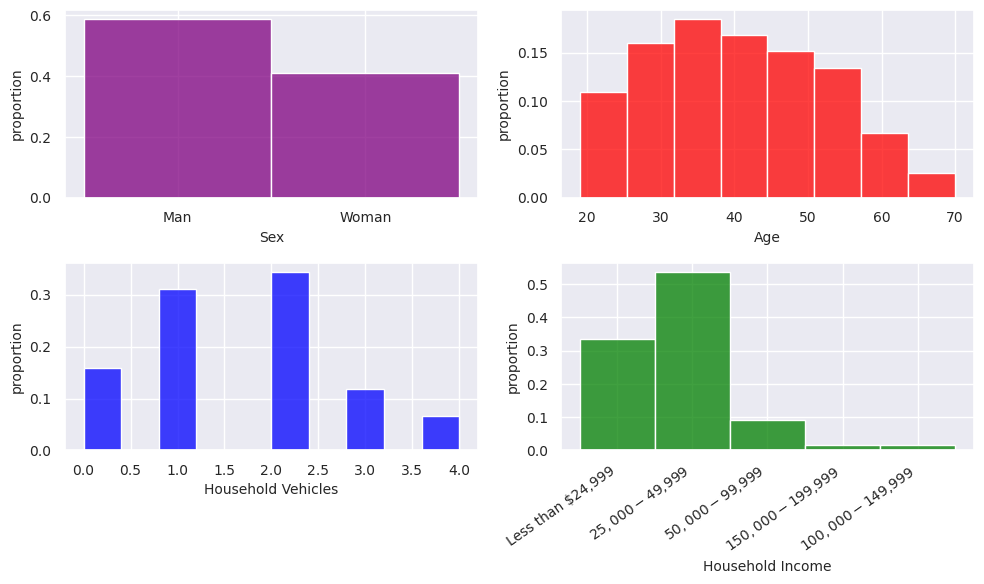

In [11]:
# Age, Income, Gender
plot_data = cleaned_data.copy()
plot_data = plot_data.groupby(['perno']).nth(0)[['AGE','GENDER','VEH_num','HHINC']].dropna()
plot_data = plot_data[plot_data['GENDER'].isin(['Man','Woman'])]

plot_title='Participant Demographics'
ylab='Count'
file_name='CanBikeCO_report_demog'
fig, axs = plt.subplots(2,2,figsize=(10,6))
sns.histplot(data=plot_data, x='GENDER', ax=axs[0,0], color='purple', stat='probability').set(xlabel='Sex',ylabel='proportion')
sns.histplot(data=plot_data, x='AGE', ax=axs[0,1], color='red', stat='probability').set(xlabel='Age',ylabel='proportion')
sns.histplot(data=plot_data, x='VEH_num', ax=axs[1,0], color='blue', stat='probability').set(xlabel='Household Vehicles',ylabel='proportion')
sns.histplot(data=pd.DataFrame(plot_data['HHINC'].dropna()), x='HHINC', ax=axs[1,1], color='green', stat='probability').set(xlabel='Household Income',ylabel='proportion')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()

fig.savefig(file_name+".png", bbox_inches='tight')

## Modes in Mini vs Full Pilot

Figure 6 in the paper

In [12]:
# processing mini data
mini_pilot_trips = pd.read_csv(to_data_folder + "/trip_program.csv")
mini_pilot_trips = mini_pilot_trips[mini_pilot_trips.program == 'prepilot']
print(len(mini_pilot_trips), "total minipilot trips")
MINI_PILOT_DF = mini_pilot_trips.copy() #saving a copy for later

# Combine variable categories
mini_pilot_trips = mini_pilot_trips.replace('Gas Car, drove alone', 'Car')
mini_pilot_trips = mini_pilot_trips.replace('Gas Car, with others', 'Shared Car')
mini_pilot_trips = mini_pilot_trips.replace('Bikeshare', 'Shared Micromobility')
mini_pilot_trips = mini_pilot_trips.replace('Scooter share', 'Shared Micromobility')
mini_pilot_trips = mini_pilot_trips.replace('Regular Bike', 'Personal Micromobility')
mini_pilot_trips = mini_pilot_trips.replace('Skate board', 'Personal Micromobility')
mini_pilot_trips = mini_pilot_trips.replace('Train', 'Transit')
mini_pilot_trips = mini_pilot_trips.replace('Free Shuttle', 'Transit')
mini_pilot_trips = mini_pilot_trips.replace('Bus', 'Transit')
mini_pilot_trips = mini_pilot_trips.replace('Walk', 'Walk')
mini_pilot_trips = mini_pilot_trips.replace('Taxi/Uber/Lyft', 'Ridehail')
mini_pilot_trips = mini_pilot_trips.replace('Pilot ebike', 'E-Bike')

#filter out 'not a trip' trips
mini_pilot_trips = mini_pilot_trips[~mini_pilot_trips['Mode_confirm'].isin(['Not a Trip'])]
mini_pilot_trips = mini_pilot_trips[~mini_pilot_trips['Replaced_mode'].isin(['Not a Trip'])]
mini_pilot_trips = mini_pilot_trips[~mini_pilot_trips['Trip_purpose'].isin(['not_a_trip'])]

print(len(mini_pilot_trips), "minipilot trips after cleaning data")

2374 total minipilot trips
2323 minipilot trips after cleaning data


/tmp/ipykernel_2028/1836037752.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mini_pilot_trips = mini_pilot_trips.replace('Gas Car, drove alone', 'Car')


In [13]:
#prepare mini and full trip dfs for plot
mini_trips_cleaned = format_for_mode_bars(mini_pilot_trips, 'Minipilot', True)
full_trips_cleaned = format_for_mode_bars(cleaned_data, 'Long Term')

plot_data = pd.concat([full_trips_cleaned, mini_trips_cleaned])
plot_data

Mode  Count  Proportion   Trip Type    Dataset
0         Car  15763    0.256246   All Trips  Long Term
1      E-bike  17365    0.282289   All Trips  Long Term
2       Other   2127    0.034577   All Trips  Long Term
3    Ridehail    324    0.005267   All Trips  Long Term
4  Shared Car  14682    0.238673   All Trips  Long Term
5     Transit   1395    0.022677   All Trips  Long Term
6        Walk   9859    0.160270   All Trips  Long Term
0         Car   3758    0.282875  Work Trips  Long Term
1      E-bike   5962    0.448777  Work Trips  Long Term
2       Other    339    0.025518  Work Trips  Long Term
3    Ridehail     80    0.006022  Work Trips  Long Term
4  Shared Car   1167    0.087843  Work Trips  Long Term
5     Transit    296    0.022281  Work Trips  Long Term
6        Walk   1683    0.126684  Work Trips  Long Term
0         Car    487    0.209643   All Trips  Minipilot
1      E-bike    733    0.315540   All Trips  Minipilot
2       Other     28    0.012053   All Trips  Minipilot
3    Ridehail     65    0.027981   All Trips  Minipilot
4  Shared Car    687    0.295738   All Trips  Minipilot
5     Transit    155    0.066724   All Trips  Minipilot
6        Walk    168    0.072320   All Trips  Minipilot
0         Car    110    0.305556  Work Trips  Minipilot
1      E-bike    122    0.338889  Work Trips  Minipilot
2       Other      0    0.000000  Work Trips  Minipilot
3    Ridehail      1    0.002778  Work Trips  Minipilot
4  Shared Car    101    0.280556  Work Trips  Minipilot
5     Transit      3    0.008333  Work Trips  Minipilot
6        Walk     23    0.063889  Work Trips  Minipilot

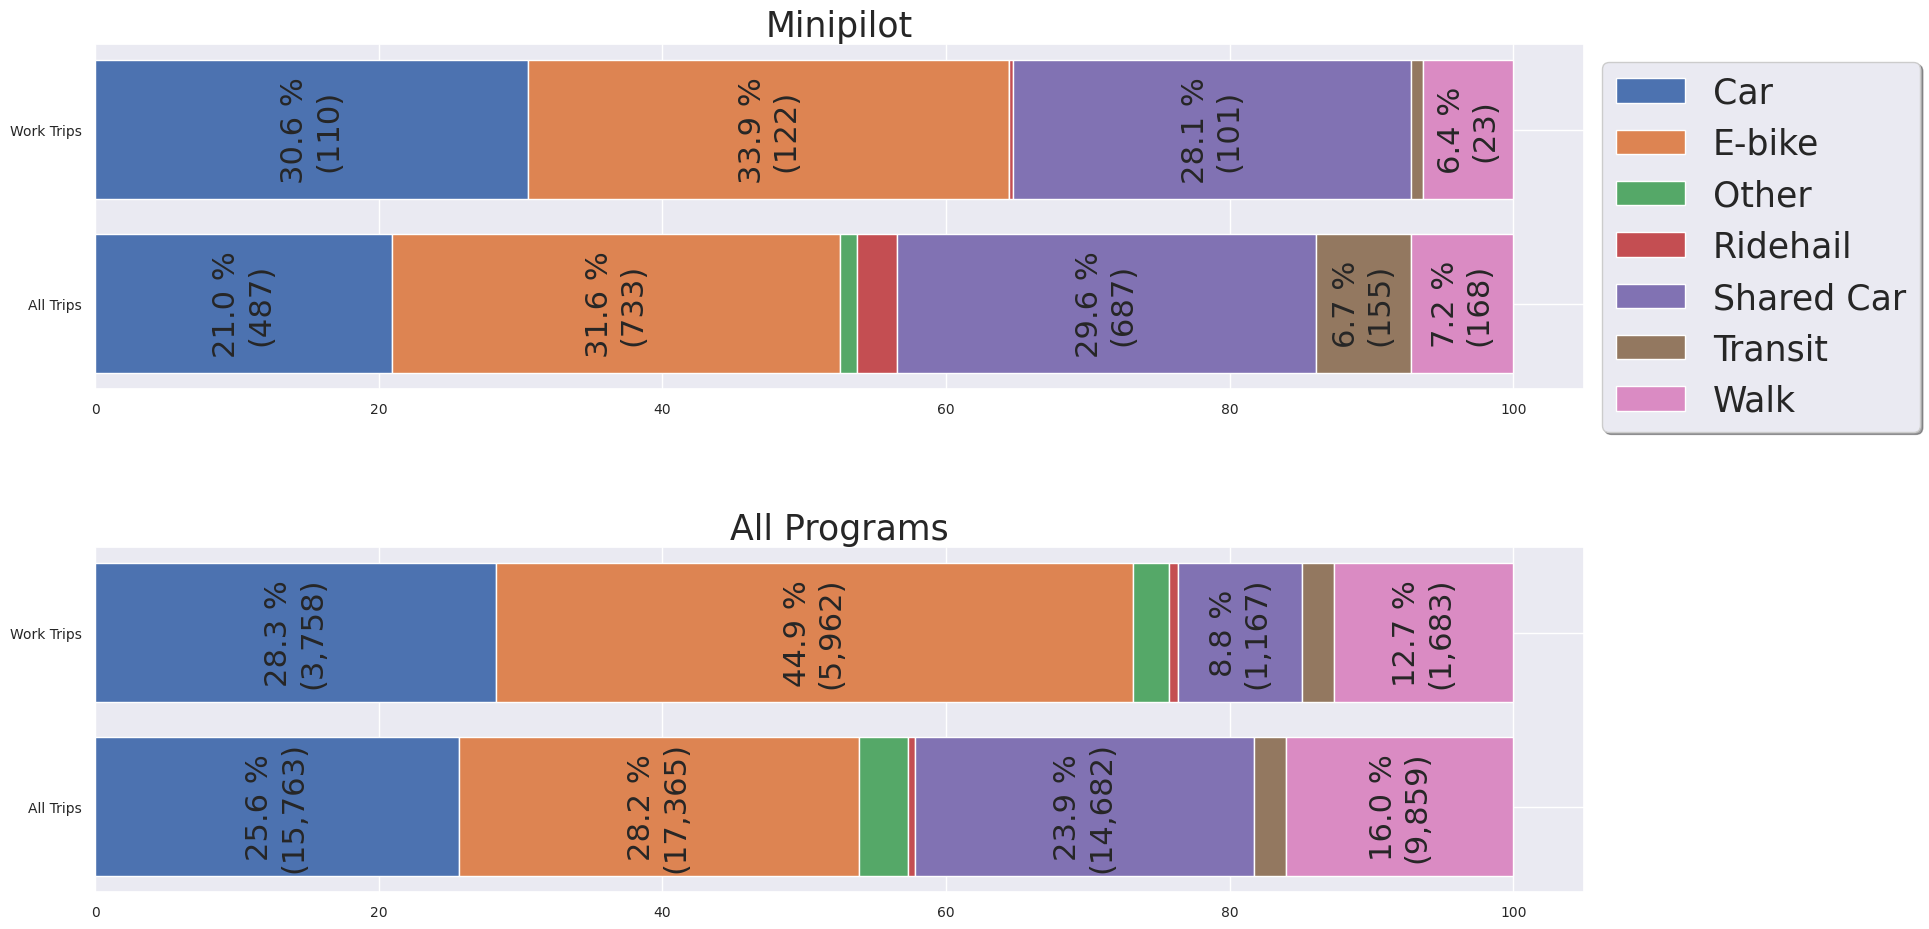

In [14]:
# make and save the chart
make_mini_vs_full(plot_data, 'Mode')

## Mode Share by Program

figure 7 in the paper

In [15]:
# process the data for the clustered chart
cleaned_data.program.unique()

array(['4c', 'cc', 'fc', 'pc', 'sc', 'vail'], dtype=object)

In [16]:
mode_data = cleaned_data.copy()

#clean up the modes
mode_data.loc[mode_data['Mode_confirm']=='Personal Micromobility', 'Mode_confirm'] = 'Other'
mode_data.loc[mode_data['Mode_confirm']=='Shared Micromobility', 'Mode_confirm'] = 'Other'

program_list = ['4c', 'cc', 'fc', 'pc', 'sc', 'vail']

work_trips = format_mode_by_program(mode_data, program_list, True)
all_trips = format_mode_by_program(mode_data, program_list, False)

In [17]:
##COLUMN ORDERS MUST MATCH OR CHART MISREPRESENTS DATA
all_trips

Mode_confirm                         Car     E-bike     Other  Ridehail  \
program                                                                   
Four Corners\n(Durango)         9.678858  54.772525  4.727921  0.089206   
Comunity Cycles\n(Boulder)     18.221551  31.551971  4.597107  0.433090   
Fort Collins                   27.674550  31.015390  2.374249  0.056306   
Pueblo                         35.525794  26.539345  1.283778  0.103019   
Smart Commute\n(Denver North)  26.933702  11.801719  3.069368  2.931246   
Vail                           41.098748  17.918405  5.771905  0.069541   

Mode_confirm                   Shared Car   Transit       Walk  
program                                                         
Four Corners\n(Durango)         24.174844  0.579839   5.976806  
Comunity Cycles\n(Boulder)      21.253179  4.223617  19.719485  
Fort Collins                    22.738363  0.394144  15.746997  
Pueblo                          28.710674  0.245661   7.591727  
Smart Commute\n(Denver North)   30.095150  0.567833  24.600982  
Vail                            18.173389  4.844692  12.123319

In [18]:
work_trips['Ridehail'] = work_trips['Ridehail'].fillna(0)
work_trips['Transit'] = work_trips['Transit'].fillna(0)
work_trips = work_trips[['Car', 'E-bike', 'Other', 'Ridehail', 'Shared Car', 'Transit', 'Walk']]

work_trips

Mode_confirm                         Car     E-bike     Other  Ridehail  \
program                                                                   
Four Corners\n(Durango)         6.226415  78.867925  1.509434  0.000000   
Comunity Cycles\n(Boulder)     22.047244  54.964471  3.495295  0.403303   
Fort Collins                   32.752263  42.507543  3.151190  0.000000   
Pueblo                         51.745898  33.824148  0.420698  0.084140   
Smart Commute\n(Denver North)  13.959234  21.680049  2.532427  3.520692   
Vail                           25.307557  45.518453  0.702988  0.000000   

Mode_confirm                   Shared Car    Transit       Walk  
program                                                          
Four Corners\n(Durango)         12.264151   0.000000   1.132075  
Comunity Cycles\n(Boulder)       5.588631   4.013828   9.487229  
Fort Collins                     9.654710   0.335233  11.599061  
Pueblo                           7.909129   0.042070   5.973917  
Smart Commute\n(Denver North)   16.924027   0.432366  40.951204  
Vail                            10.720562  12.126538   5.623902

### make and save the clustered chart

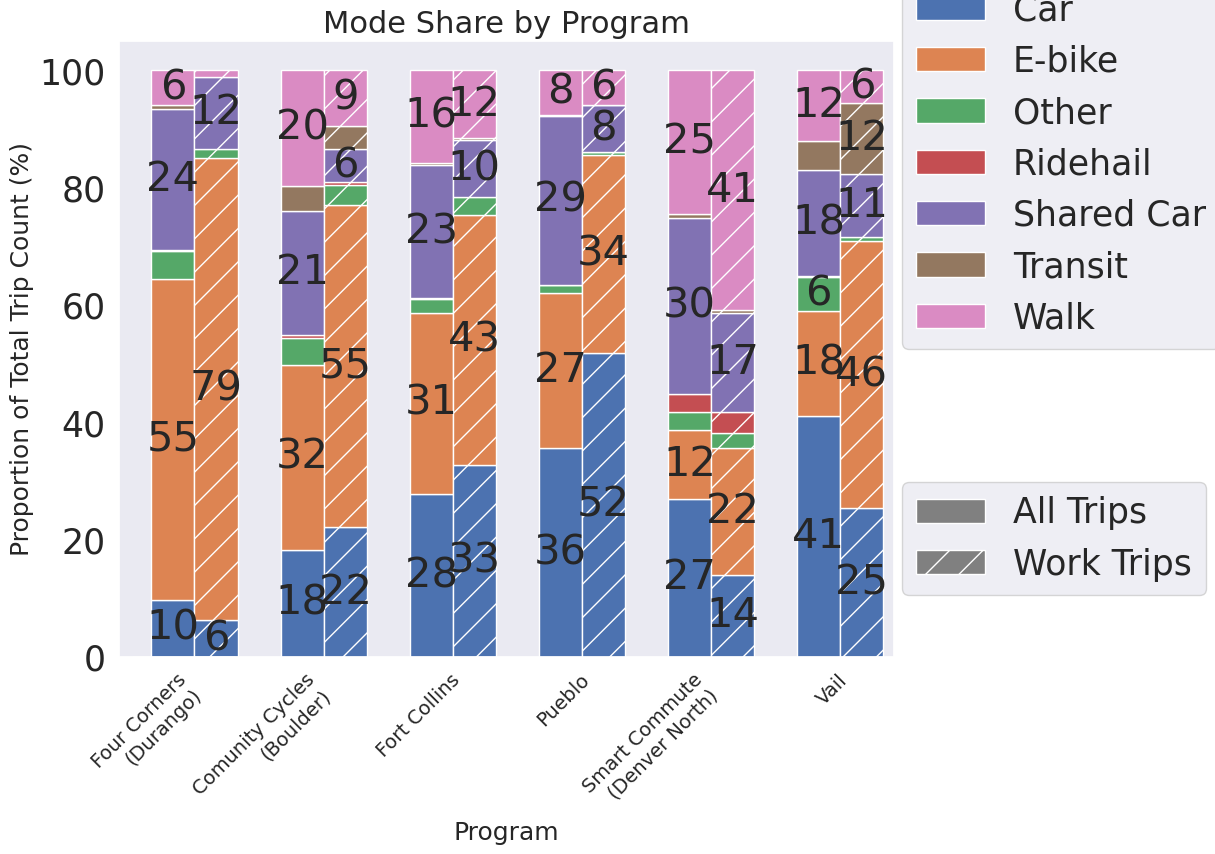

In [19]:
#call function to create chart:
ax = plot_clustered_stacked([all_trips, work_trips],["All Trips", "Work Trips"], title = "Mode Share by Program")

for c in ax.containers:
    labels = [f'{round(v.get_height())}' if v.get_height() > 5 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')
    
ax.set_xticklabels(all_trips.index, rotation=45, ha='right', fontsize=14)

ax.set_xlabel('Program', fontsize = 18)
ax.set_ylabel('Proportion of Total Trip Count (%)', fontsize = 18)

plt.savefig("CanBikeCO_report_mode_share_overview.jpeg", bbox_inches='tight')

## Trip Purpose Mini vs Full

figure 8 in the paper

In [20]:
#arrange the data
full_purpose_data = cleaned_data.copy()
mini_purpose_data = MINI_PILOT_DF.copy()

mini_pilot_trips = format_purpose_bars(mini_purpose_data, "Minipilot")
plot_data = format_purpose_bars(full_purpose_data, "Long Term")

plot_data = pd.concat([plot_data, mini_pilot_trips])

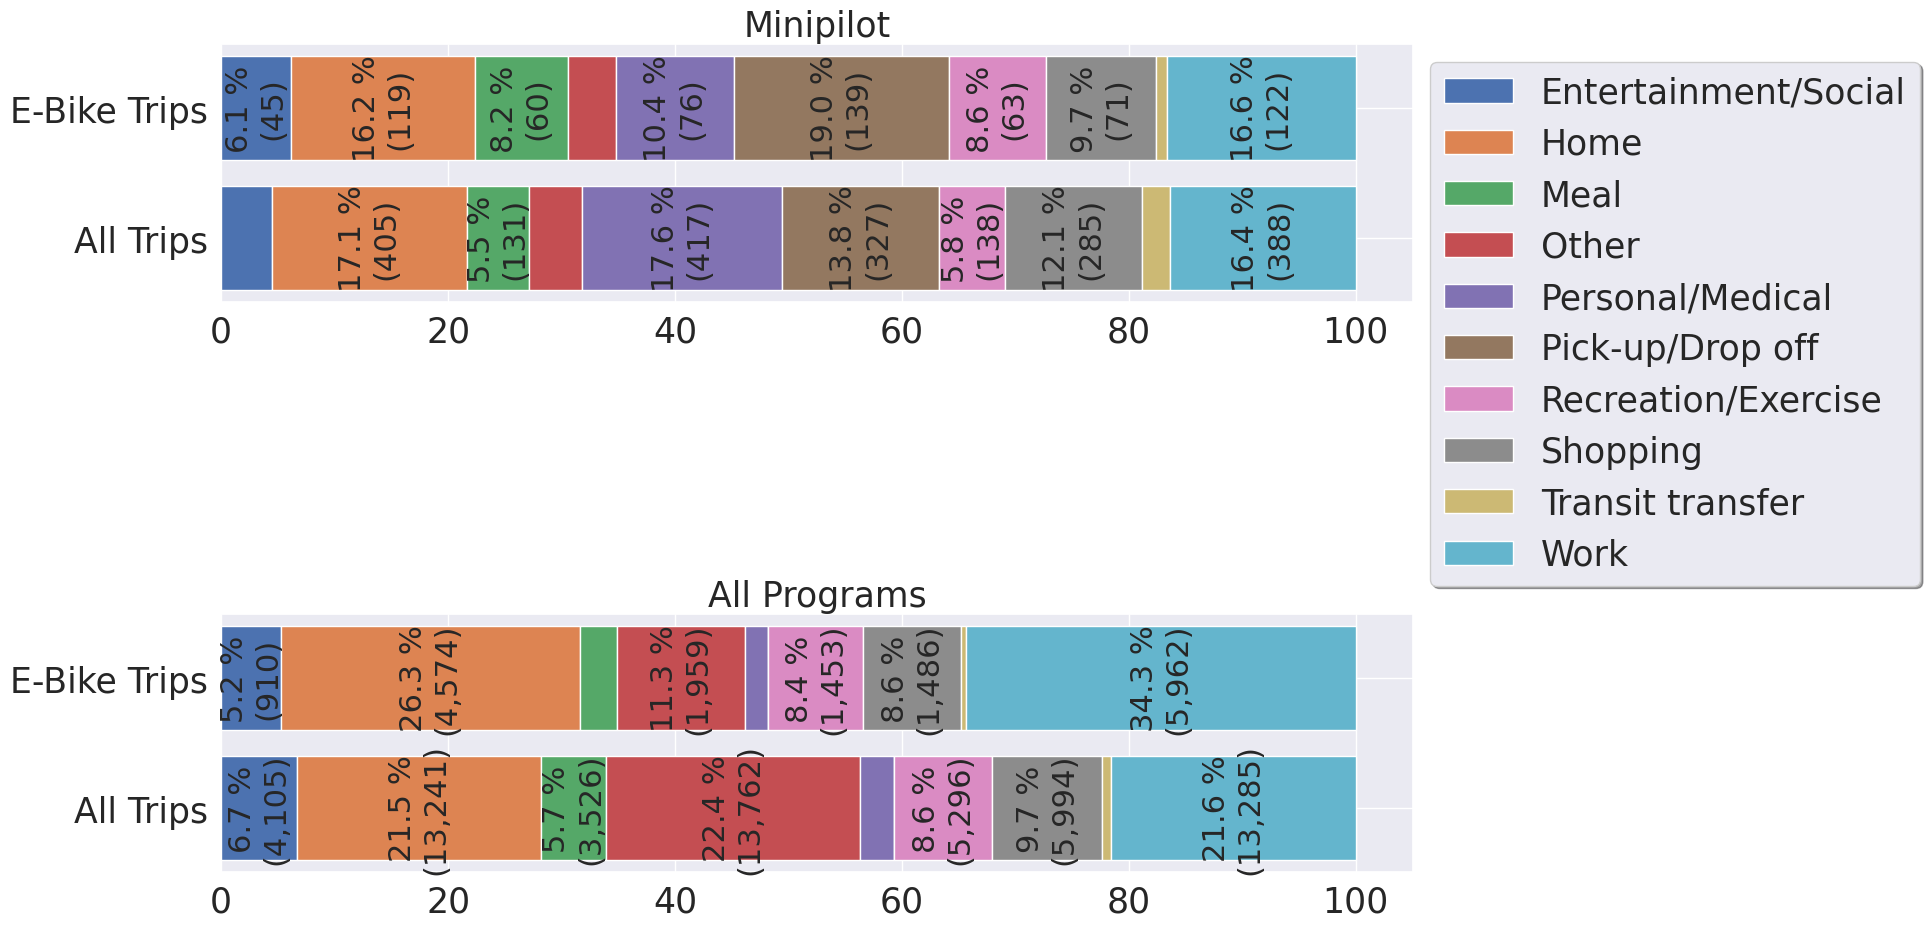

In [21]:
# create the chart
make_mini_vs_full(plot_data, 'Purpose')

## Show what purposes different programs used the e-bikes for

figure 9 in the paper

In [22]:
full_purpose_data = cleaned_data.copy()
e_purpose = full_purpose_data[full_purpose_data.Mode_confirm == 'E-bike']

e_purpose.loc[e_purpose['Trip_purpose']=='Religious', 'Trip_purpose'] = 'Other'
e_purpose.loc[e_purpose['Trip_purpose']=='School', 'Trip_purpose'] = 'Other'

program_list = ['4c', 'cc', 'fc', 'pc', 'sc', 'vail']
all_plot_data = []
for program in program_list:
    program_data = e_purpose[mode_data.program == program]

    t1 = program_data[['Trip_purpose','distance_miles']]
    t1 = t1.groupby(['Trip_purpose'], as_index=False).sum()
    t1['distance_miles'].fillna(0, inplace=True)
    t1[program] = (t1['distance_miles'] / np.sum(t1.distance_miles)) * 100
    t1 = t1.set_index('Trip_purpose')
    t1 = t1.drop(columns = ['distance_miles'])
    all_plot_data.append(t1)
    
all_trips = pd.concat(all_plot_data, axis = 1)

all_trips = all_trips.transpose()

all_trips['program'] = all_trips.index
all_trips = all_trips.replace({'4c': 'Four Corners\n(Durango)', 
                               'cc': 'Comunity Cycles\n(Boulder)',
                               'sc': 'Smart Commute\n(Denver North)',
                               'pc':'Pueblo',
                               'vail':'Vail',
                               'fc':'Fort Collins'})
all_trips = all_trips.set_index('program')

all_trips

/tmp/ipykernel_2028/2496704132.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  program_data = e_purpose[mode_data.program == program]
/tmp/ipykernel_2028/2496704132.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  t1['distance_miles'].fillna(0, inplace=True)
/tmp/ipykernel_2028/2496704132.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  program_data = e_purpose[mode_data.program == program]
/tmp/ipykernel_2028/2496704132.py:14: FutureWarning: A value 

Trip_purpose                   Entertainment/Social       Home      Meal  \
program                                                                    
Four Corners\n(Durango)                    3.586900  33.540561  4.331342   
Comunity Cycles\n(Boulder)                 3.184424  31.085889  2.888382   
Fort Collins                               2.182344  27.295081  2.067012   
Pueblo                                    21.465674  12.907053  2.325854   
Smart Commute\n(Denver North)              2.324331  35.126383  1.852444   
Vail                                       3.251829  32.426163  5.338610   

Trip_purpose                       Other  Personal/Medical  \
program                                                      
Four Corners\n(Durango)         8.693450          0.236491   
Comunity Cycles\n(Boulder)      9.649842          1.783206   
Fort Collins                   11.727759          2.502932   
Pueblo                         15.152311          4.131477   
Smart Commute\n(Denver North)   2.791532          0.375686   
Vail                           13.396808          0.985428   

Trip_purpose                   Recreation/Exercise  Shopping  \
program                                                        
Four Corners\n(Durango)                   5.022724  9.145178   
Comunity Cycles\n(Boulder)               10.114074  6.046249   
Fort Collins                              7.898888  9.947937   
Pueblo                                   24.364485  5.881472   
Smart Commute\n(Denver North)             4.565950  2.674597   
Vail                                      5.274282  6.361933   

Trip_purpose                   Transit transfer       Work  
program                                                     
Four Corners\n(Durango)                0.170526  35.272829  
Comunity Cycles\n(Boulder)             0.521358  34.726575  
Fort Collins                           0.684368  35.693678  
Pueblo                                 0.408723  13.362951  
Smart Commute\n(Denver North)          0.135057  50.154019  
Vail                                   0.506718  32.458230

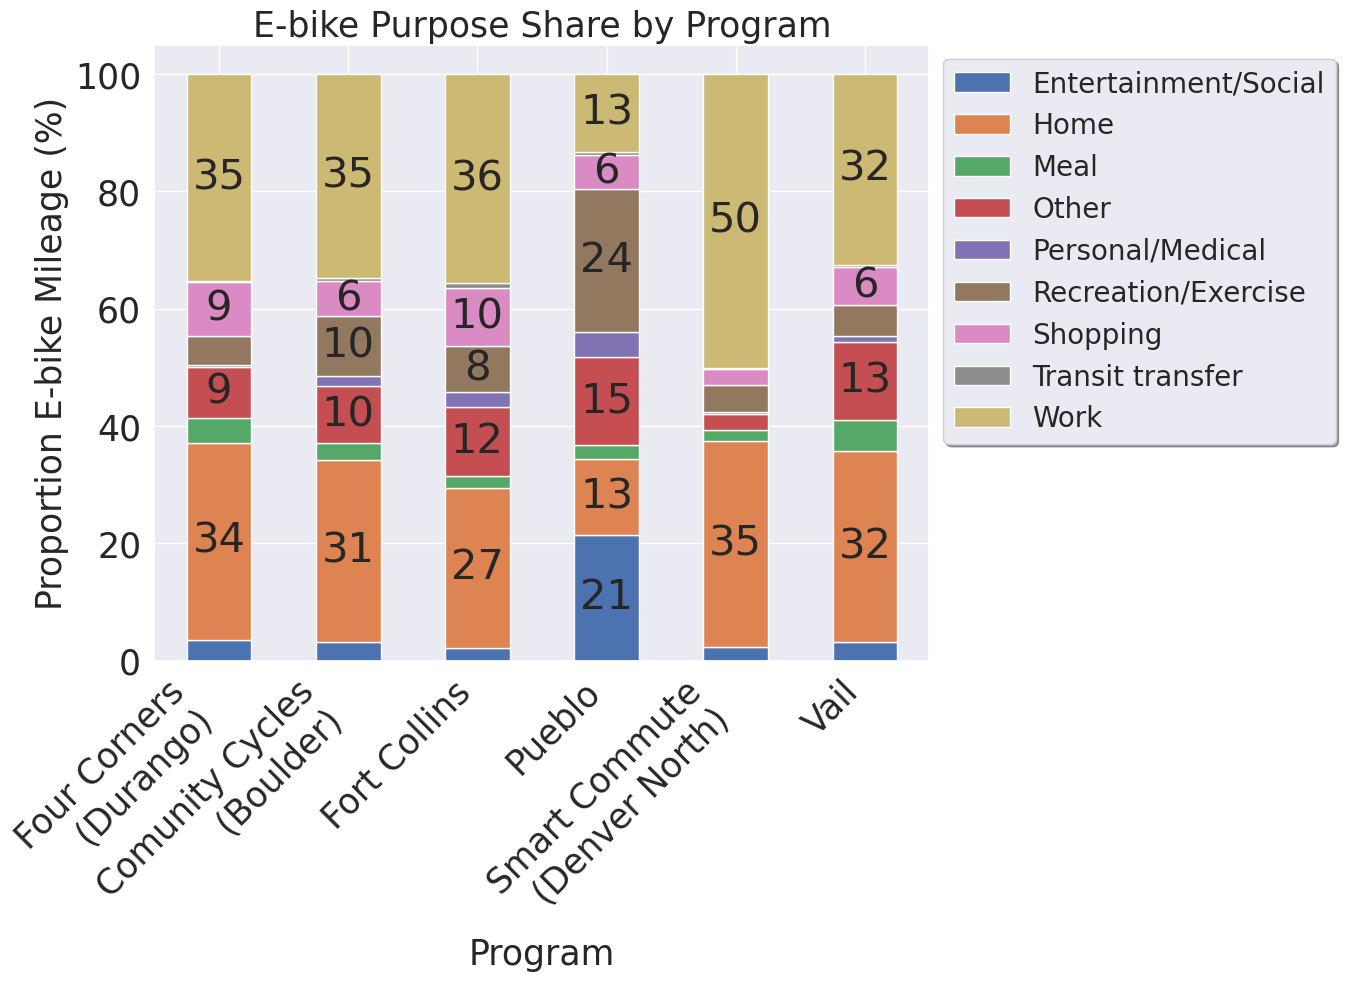

In [23]:
#plot purposes by program
make_stacked_bars(all_trips, "E-bike Purpose Share by Program", "Program", "Proportion E-bike Mileage (%)", "CanBikeCO_report_ebike_programs_purp_share.jpeg")

## Mode share by age

figure 11 in the paper

In [24]:
mode_data = cleaned_data.copy() #complete set of cleaned data

age_counts = mode_data.groupby(['AGE'], as_index=False).count()[['AGE', 'user_id']]

bins = [18, 30, 42, 54, 66]
mode_data['age_bin'] = pd.cut(mode_data['AGE'], bins)

age_modes = mode_data.groupby(['age_bin', 'Mode_confirm'], as_index=False).count()[['age_bin', 'Mode_confirm','distance_miles']]
age_modes['proportion'] = age_modes['distance_miles'] / np.sum(age_modes.distance_miles)

list_age_modes = []
for age_bin in age_modes.age_bin.unique():
    age_data = mode_data[mode_data['age_bin'] == age_bin]

    age_bin_df = age_data.groupby(['Mode_confirm'], as_index=False).count()[['Mode_confirm','distance_miles']]
    age_bin_df['distance_miles'].fillna(0, inplace=True)
    age_bin_df[age_bin] = (age_bin_df['distance_miles'] / np.sum(age_bin_df.distance_miles)) * 100
    age_bin_df = age_bin_df.set_index('Mode_confirm')
    age_bin_df = age_bin_df.drop(columns = ['distance_miles'])
    list_age_modes.append(age_bin_df)
        
age_modes = pd.concat(list_age_modes, axis = 1)
age_modes = age_modes.transpose()
age_modes = age_modes.fillna(0)

age_modes

/tmp/ipykernel_2028/3204690002.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_modes = mode_data.groupby(['age_bin', 'Mode_confirm'], as_index=False).count()[['age_bin', 'Mode_confirm','distance_miles']]
/tmp/ipykernel_2028/3204690002.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  age_bin_df['distance_miles'].fillna(0, inpla

Mode_confirm        Car     E-bike     Other  Personal Micromobility  \
(18, 30]      10.925905  33.245804  3.447882                2.705788   
(30, 42]      24.963113  25.388601  2.388224                1.441169   
(42, 54]      24.679417  32.959625  0.534916                1.179746   
(54, 66]      41.623117  26.109233  0.348396                0.655805   

Mode_confirm  Ridehail  Shared Car  Shared Micromobility   Transit       Walk  
(18, 30]      0.182669   26.372874              0.616509  3.596301  18.906268  
(30, 42]      0.878427   25.271935              0.233332  2.377930  17.057269  
(42, 54]      0.322415   26.679856              0.073276  2.601304  10.969444  
(54, 66]      0.051235   13.433753              0.051235  0.327902  17.399324

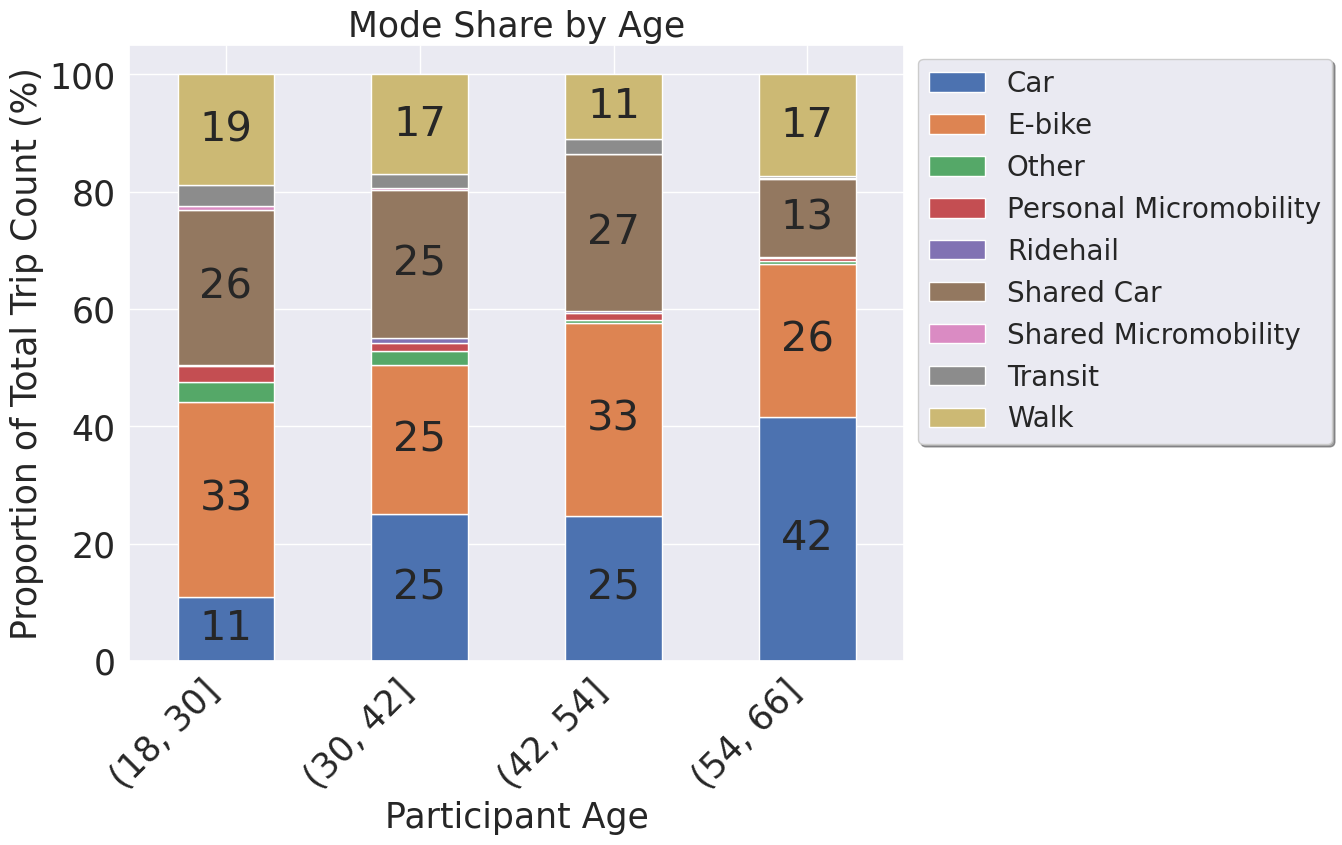

In [25]:
#plot mode share by age
make_stacked_bars(age_modes, "Mode Share by Age", "Participant Age", "Proportion of Total Trip Count (%)", "CanBikeCO_report_age_mode_share.jpeg")

## e-bike distances by program

figure 5 in the paper

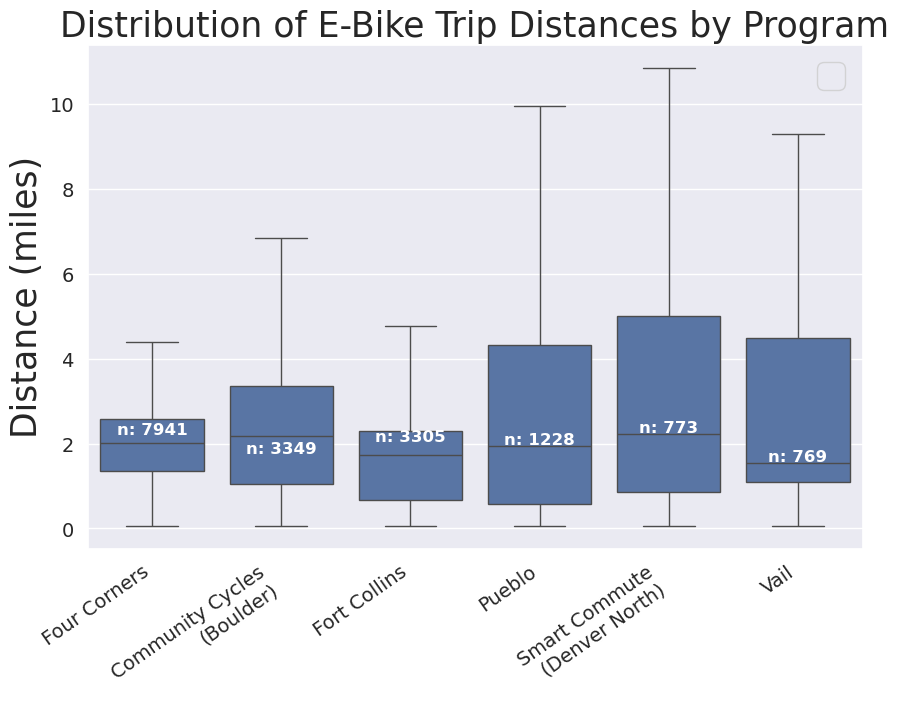

In [26]:
# Distribution of distances by program
plot_data = cleaned_data.copy()
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data['Program'] = plot_data['program'].replace(['4c','cc','fc','pc','sc','vail'],['Four Corners','Community Cycles\n(Boulder)','Fort Collins','Pueblo','Smart Commute\n(Denver North)','Vail'])

plot_title = 'Distribution of E-Bike Trip Distances by Program'
ylab = 'Distance (miles)'

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(ax=ax, data=plot_data, x='Program', y='distance_miles', hue='Mode_confirm', showfliers=False).set(title=plot_title, xlabel='', ylabel=ylab)
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=35, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.legend([])

# Calculate number of obs per group & median to position labels
medians = plot_data.groupby(['Program'])['distance_miles'].median().values
nobs = plot_data['Program'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            medians[tick] + 0.03,
            nobs[tick],
            horizontalalignment='center',
            size='12',
            color='w',
            weight='semibold')
 
plt.savefig("CanBikeCO_report_e-bike_miles_dist.jpeg", bbox_inches='tight')

## E-bike trips across occuptations

figures 13 and 25

In [27]:
data = cleaned_data.copy()
data['occupation_cat'] = data['which_best_describes_your_primary_job?'].replace(['Sales or service',
                                                                                 'Manufacturing, construction, maintenance, or farming',                                                                            
                                                                                 'Janitorial',
                                                                                 'Professional, managerial, or technical',
                                                                                 'Clerical or administrative support',
                                                                                 'Teacher',
                                                                                 'Medical',
                                                                                 'CNA',
                                                                                 'Restaurant manager',
                                                                                 'Co op laundry',
                                                                                 'Cook',
                                                                                 'Nurse',
                                                                                 'Dining Services',
                                                                                 'Security',
                                                                                 'Food service',
                                                                                 'Csu custodian',
                                                                                 'Residential Dining Services',
                                                                                 'education/early childhood',
                                                                                 'Inbound cs',
                                                                                 'Custodial Maintanace',
                                                                                 'Amazon',
                                                                                 'Custodian',
                                                                                 'Hockey rink',
                                                                                 'Pastry chef and line cook',                                                                                 
                                                                                 'Cooking',
                                                                                 'Education non-profit manager',
                                                                                 'Healthcare',
                                                                                 'Chef',
                                                                                 'Accounting Technician',
                                                                                 'Caregiver/ Qmap',
                                                                                 'Caregiver',
                                                                                 'Health care',
                                                                                 'Medical field'],
                                                                                ['Sales or Service',
                                                                                 'Manufacturing, Construction, Maintenance, or Farming',
                                                                                 'Custodial',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Clerical or Administrative Support',
                                                                                 'Education',
                                                                                 'Medical/Healthcare',
                                                                                 'Medical/Healthcare',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Sales or Service',
                                                                                 'Sales or Service',
                                                                                 'Medical/Healthcare',
                                                                                 'Sales or Service',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Sales or Service',
                                                                                 'Custodial',
                                                                                 'Sales or Service',
                                                                                 'Education',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Custodial',
                                                                                 'Sales or Service',
                                                                                 'Custodial',
                                                                                 'Sales or Service',
                                                                                 'Sales or Service',
                                                                                 'Sales or Service',
                                                                                 'Education',
                                                                                 'Medical/Healthcare',
                                                                                 'Sales or Service',
                                                                                 'Professional, Managerial, or Technical',
                                                                                 'Medical/Healthcare',
                                                                                 'Medical/Healthcare',
                                                                                 'Medical/Healthcare',
                                                                                 'Medical/Healthcare'])
data['occupation_cat'].unique()

array(['Sales or Service', 'Cooking ', 'Food Service',
       'Professional, Managerial, or Technical', 'Medical/Healthcare',
       'Clerical or Administrative Support', 'Education ',
       'Manufacturing, Construction, Maintenance, or Farming',
       'Accounting Technician ', 'Education', 'Custodial',
       'Csu custodian ', 'Custodial ', nan, 'Maintenance', 'Maintenance ',
       'Janitorial ', 'Amazon ', 'Custodial Maintanace ', 'Hockey rink '],
      dtype=object)

In [28]:
data['occupation_cat']= data['occupation_cat'].replace(['Food Service', 'Cooking ', 'Accounting Technician ','Education ',
                                                       'Csu custodian ','Custodial ','Maintenance ','Maintenance','Janitorial ',
                                                       'Amazon ', 'Custodial Maintanace ', 'Hockey rink '],
                                                      ['Sales or Service' , 'Sales or Service', 'Professional, Managerial, or Technical',
                                                      'Education', 'Custodial', 'Custodial', 'Custodial', 'Custodial', 'Custodial',
                                                      'Sales or Service','Custodial' ,'Sales or Service'])

data['occupation_cat'] = data['occupation_cat'].replace(['Manufacturing, Construction, Maintenance, or Farming', 'Professional, Managerial, or Technical', 'Clerical or Administrative Support'],
                                                        ['Manufacturing, Construction,\nMaintenance, or Farming', 'Professional, Managerial,\nor Technical', 'Clerical or\nAdministrative Support'])
data['occupation_cat'].unique()

array(['Sales or Service', 'Professional, Managerial,\nor Technical',
       'Medical/Healthcare', 'Clerical or\nAdministrative Support',
       'Education',
       'Manufacturing, Construction,\nMaintenance, or Farming',
       'Custodial', nan], dtype=object)

In [29]:
plot_data_1=data[data['occupation_cat'].notnull()]

/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:197: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mode_dist_by_user['distance_miles'].fillna(0, inplace=True)
/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:201: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

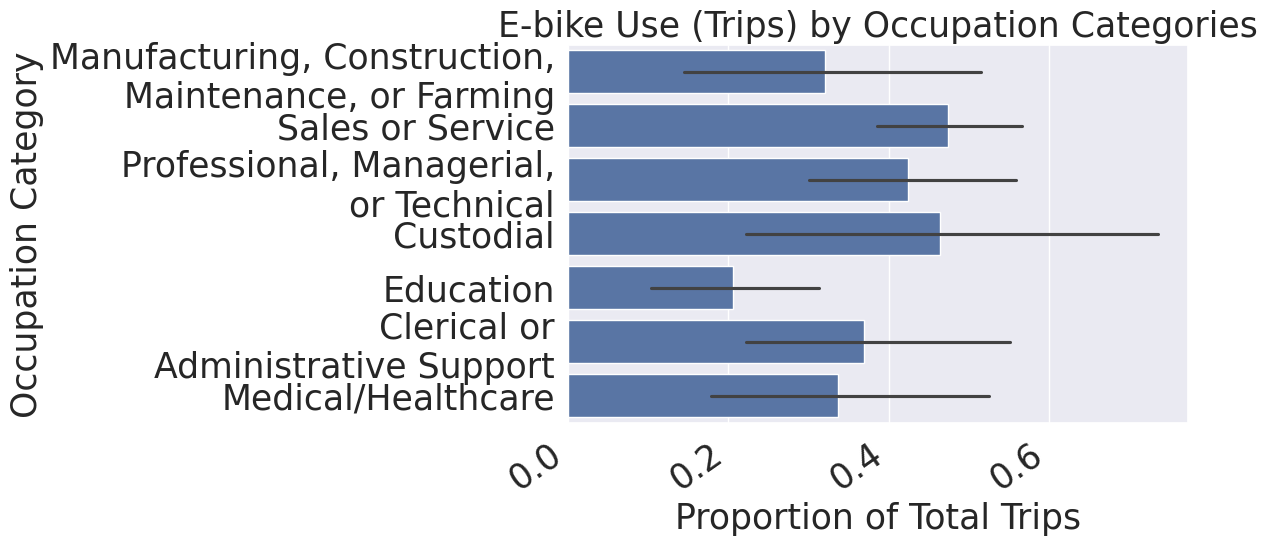

In [30]:
# proportion of trips by occupation
make_occupation_chart(plot_data_1, 'E-bike Use (Trips) by Occupation Categories', 'CanBikeCO_report_occ_ebike_trips.jpeg')

/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:197: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mode_dist_by_user['distance_miles'].fillna(0, inplace=True)
/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:201: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

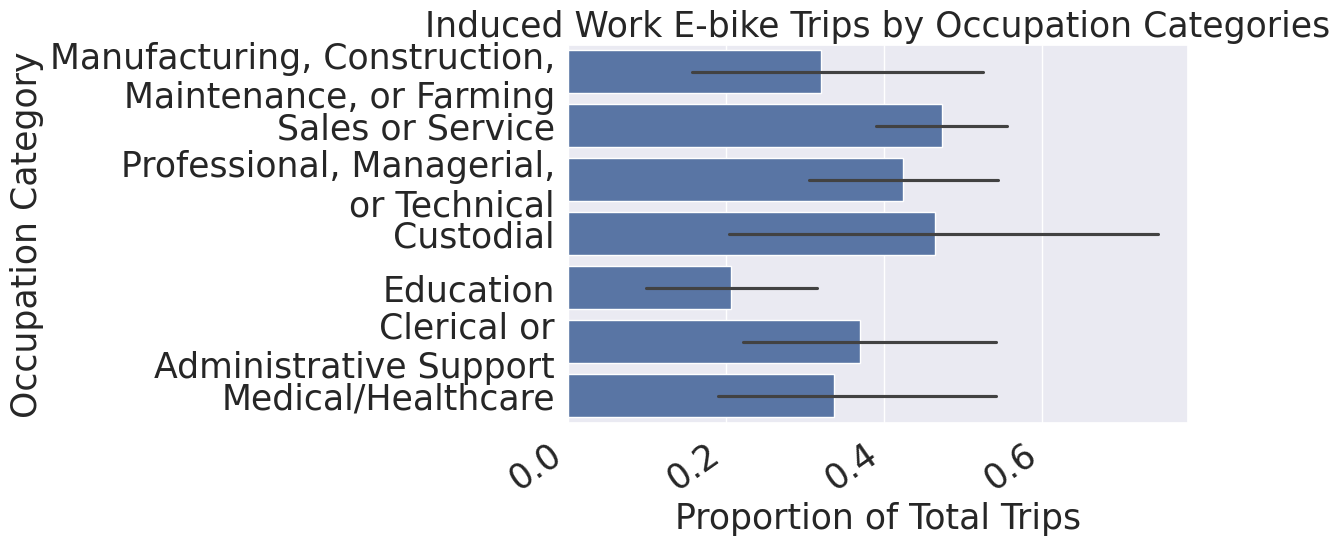

In [31]:
#format more data
data['induced']=np.where(data['Replaced_mode']=='No Travel', 'Induced', 'Non-induced')
data['Program'] = data['program'].replace(['4c','cc','fc','pc','sc','vail'],['Four Corners (Durango)','Community Cycles (Boulder)','Fort Collins','Pueblo County','Smart Commute (Denver North)','Vail'])

# proportion of induced trips by occupation
make_occupation_chart(data, 'Induced Work E-bike Trips by Occupation Categories', 'CanBikeCO_report_occ_induced_ebike_trips.jpeg')

## substitutions
Figure num 23

/tmp/ipykernel_2028/987639463.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  t1['distance_miles'].fillna(0, inplace=True)
/tmp/ipykernel_2028/987639463.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

[Text(0, 10, '0.34'),
 Text(0, 10, '0.22'),
 Text(0, 10, '0.11'),
 Text(0, 10, '0.10'),
 Text(0, 10, '0.09'),
 Text(0, 10, '0.08'),
 Text(0, 10, '0.03'),
 Text(0, 10, '0.02'),
 Text(0, 10, '0.00'),
 Text(0, 10, '0.00')]

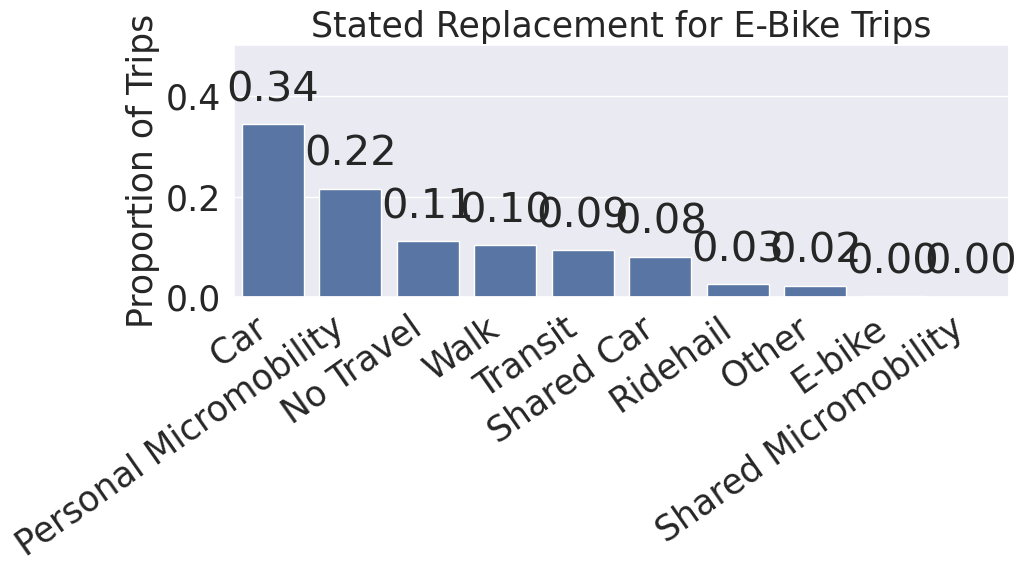

In [32]:
# Substitution rate of ebike trips
plot_data = cleaned_data.copy()
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']

t1 = plot_data[['Mode_confirm','Replaced_mode','distance_miles']]
t1 = t1.groupby(['Mode_confirm','Replaced_mode'], as_index=False).count()
t1['distance_miles'].fillna(0, inplace=True)

t2 = plot_data[['Mode_confirm','distance_miles']]
t2 = t2.groupby(['Mode_confirm'], as_index=False).count()
plot_data = t1.merge(t2, on='Mode_confirm')
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)

data_order = plot_data.copy()[['Replaced_mode', 'proportion']]
data_order = data_order.groupby(['Replaced_mode'], as_index=False).mean().sort_values('proportion', ascending=False).Replaced_mode
labels = data_order.copy()

plot_title='Stated Replacement for E-Bike Trips'
ylab='Proportion of Trips'

fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=plot_data, x='Replaced_mode', y='proportion', estimator=np.mean, order=data_order).set(title=plot_title,xlabel='',ylabel=ylab,ylim=(0,.5))
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.bar_label(ax.containers[0], fmt='%.2f', padding=10)

## E-bike Mileage change over time
Figure #20

/tmp/ipykernel_2028/829426461.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  t1['distance_miles'].fillna(0, inplace=True)
/tmp/ipykernel_2028/829426461.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

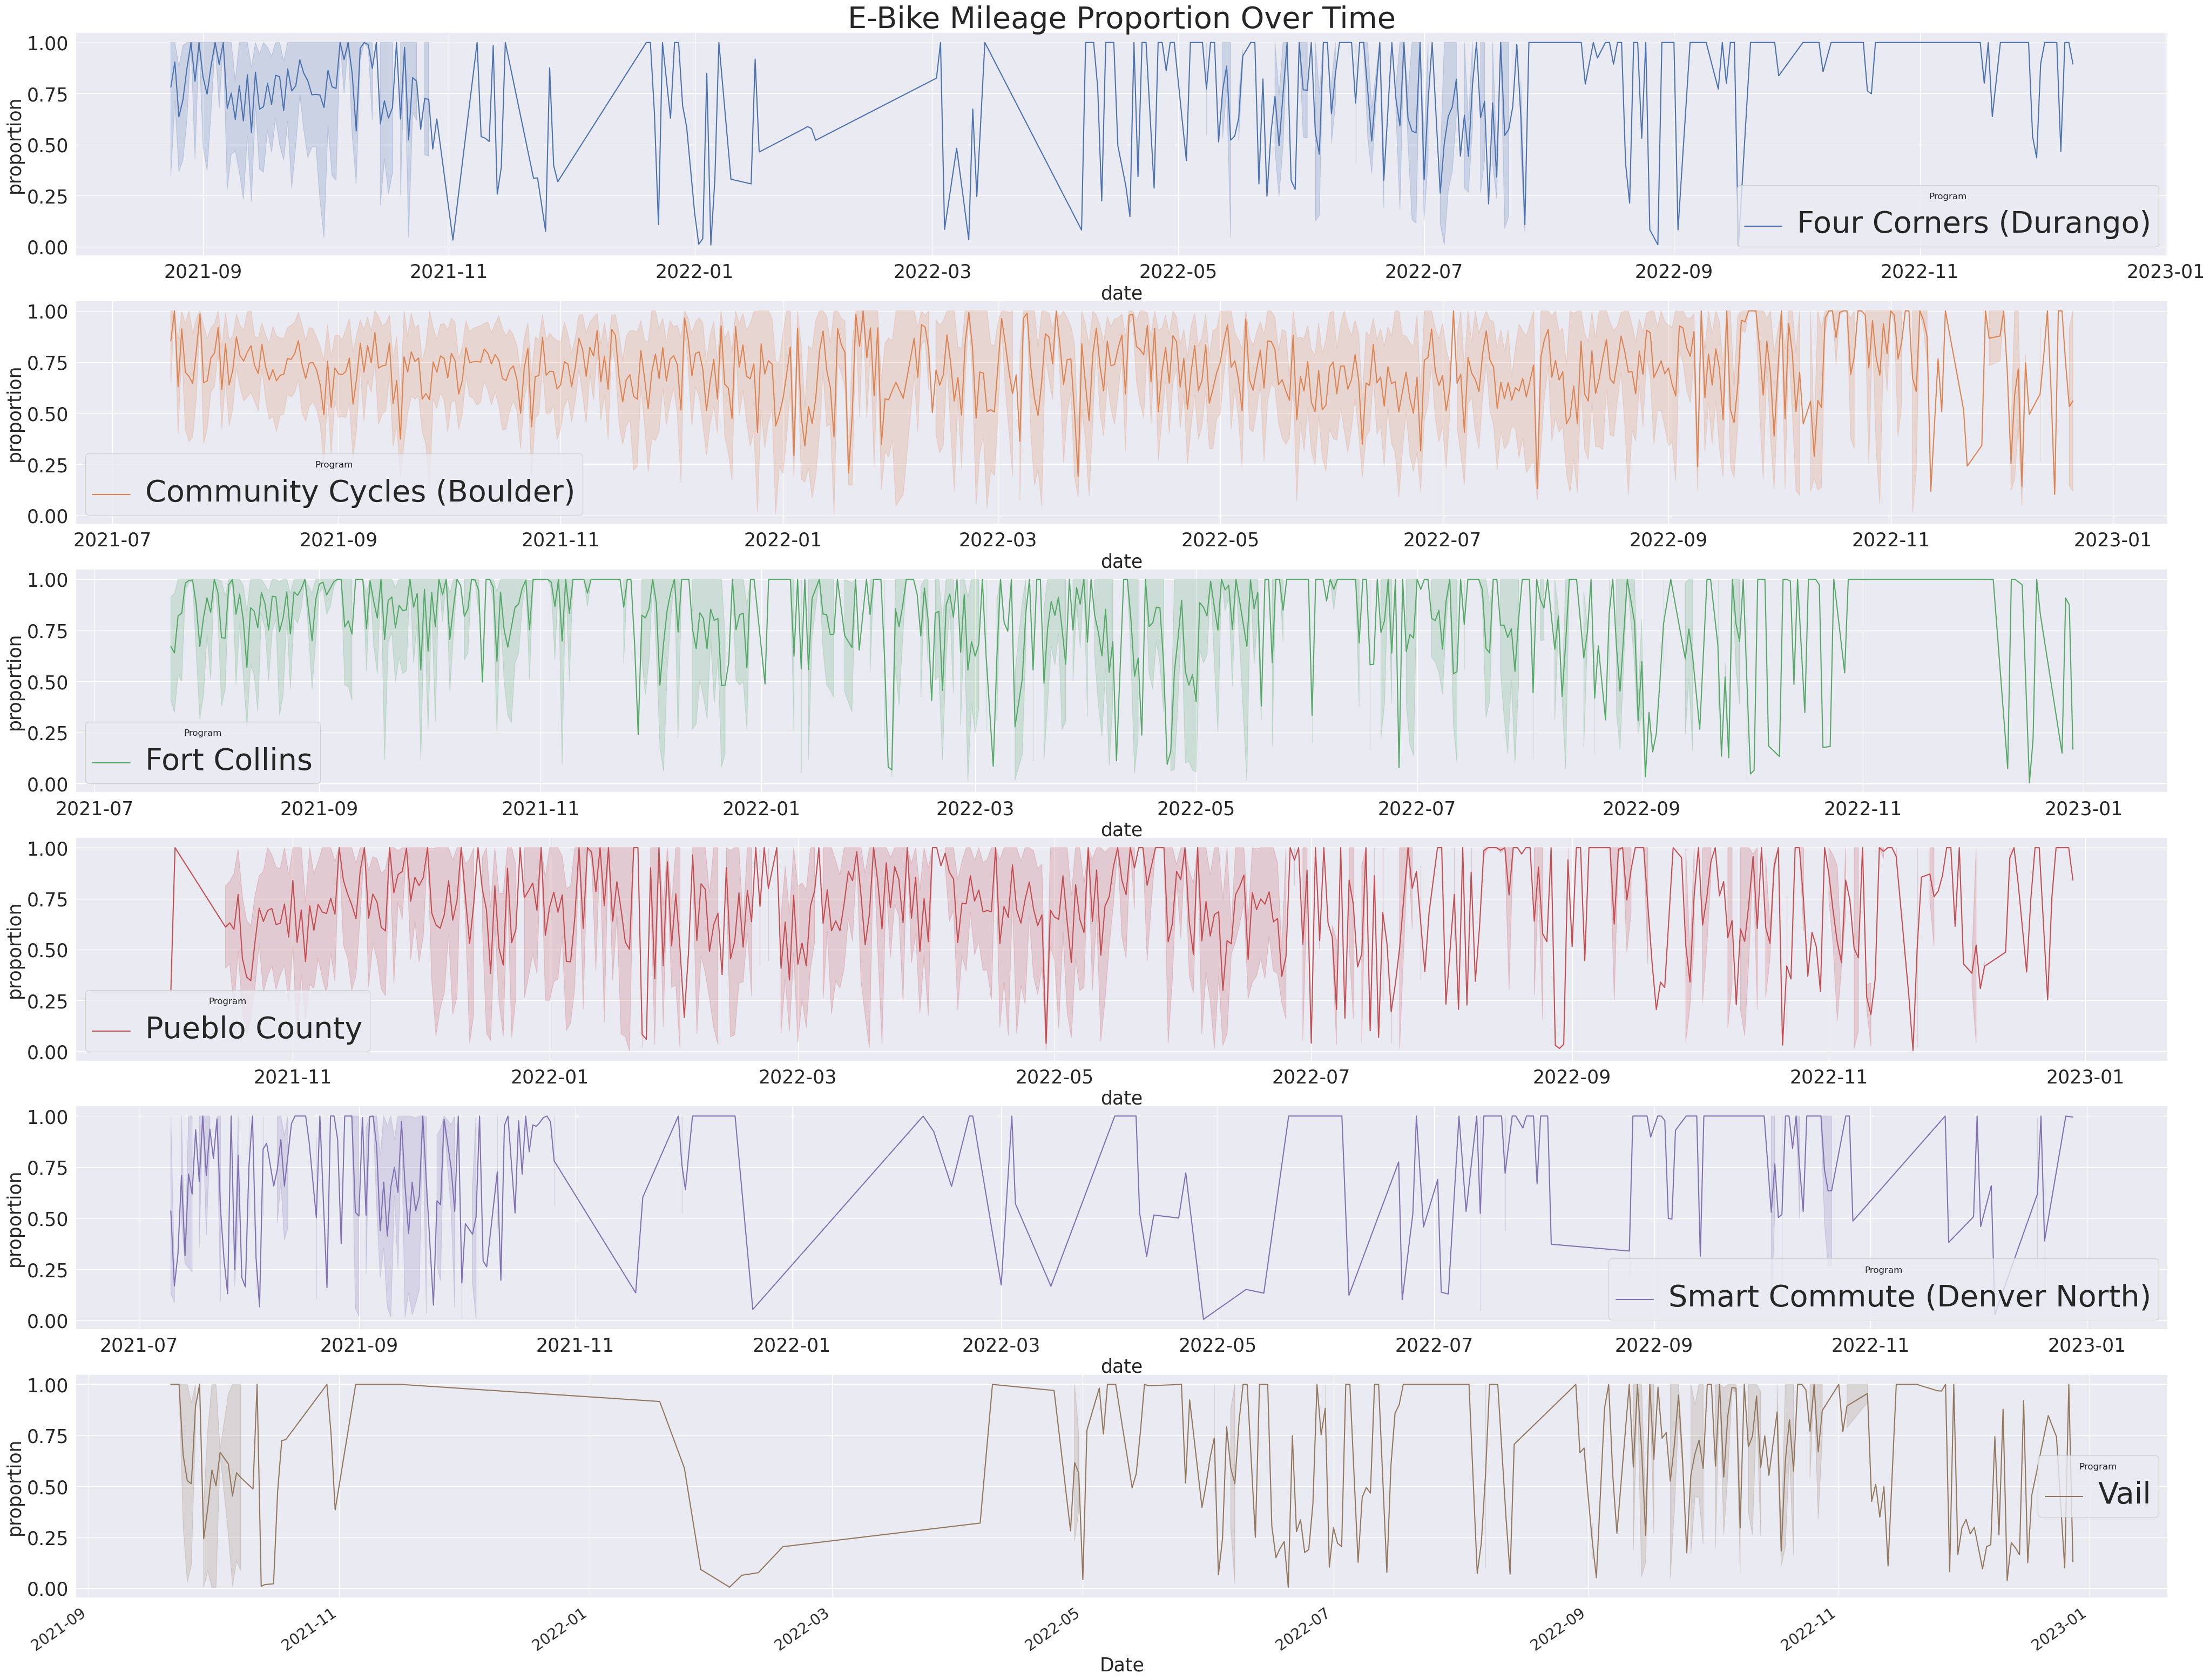

In [33]:
# How ebike mileage changes over time
from datetime import datetime
plot_data = cleaned_data.copy()
plot_data ['date'] = pd.to_datetime(plot_data['date_time'])
plot_data['Program'] = plot_data['program'].replace(['4c','cc','fc','pc','sc','vail'],['Four Corners (Durango)','Community Cycles (Boulder)','Fort Collins','Pueblo County','Smart Commute (Denver North)','Vail'])
t1 = plot_data.copy()[['user_id','date','Mode_confirm','distance_miles']]
t1 = t1.groupby(['user_id','date','Mode_confirm'], as_index=False).sum()
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.copy()[['user_id','Program','date','distance_miles']]
t2 = t2.groupby(['user_id','Program','date'], as_index=False).sum()
plot_data = t1.merge(t2, on=['user_id','date'])
plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data[plot_data['distance_miles_y'].notnull()]

plot_title = 'E-Bike Mileage Proportion Over Time'
fig, ax = plt.subplots(6,1, figsize=(50,50))
sns.lineplot(data=plot_data[plot_data.Program == "Four Corners (Durango)"], x='date', y='proportion',color="red", hue='Program', estimator=np.mean, ax=ax[0])
ax[0].set_title(plot_title, fontsize=40)
sns.lineplot(data=plot_data[plot_data.Program == "Community Cycles (Boulder)"], x='date', y='proportion', color="blue",hue='Program',estimator=np.mean, ax=ax[1], palette=["C1"])
sns.lineplot(data=plot_data[plot_data.Program == "Fort Collins"], x='date', y='proportion', color="green",hue='Program',estimator=np.mean, ax=ax[2], palette=["C2"])
sns.lineplot(data=plot_data[plot_data.Program == "Pueblo County"], x='date', y='proportion',color="cyan",hue='Program', estimator=np.mean, ax=ax[3], palette=["C3"])
sns.lineplot(data=plot_data[plot_data.Program == "Smart Commute (Denver North)"], x='date', y='proportion',color="purple",hue='Program', estimator=np.mean, ax=ax[4], palette=["C4"])
sns.lineplot(data=plot_data[plot_data.Program == "Vail"], x='date', y='proportion', color="orange",hue='Program',estimator=np.mean, ax=ax[5], palette=["C5"])
ax[5].set(xlabel='Date')
plt.setp(ax[0].get_legend().get_texts(), fontsize='40')
plt.setp(ax[1].get_legend().get_texts(), fontsize='40')
plt.setp(ax[2].get_legend().get_texts(), fontsize='40')
plt.setp(ax[3].get_legend().get_texts(), fontsize='40')
plt.setp(ax[4].get_legend().get_texts(), fontsize='40')
plt.setp(ax[5].get_legend().get_texts(), fontsize='40')
plt.xticks(rotation=35, ha='right', fontsize=20)
plt.subplots_adjust(bottom=0.30)
fig.savefig(r'mileage_over_time', bbox_inches='tight')

## distributions of distances and durations by mode

Figures #4a and 4b

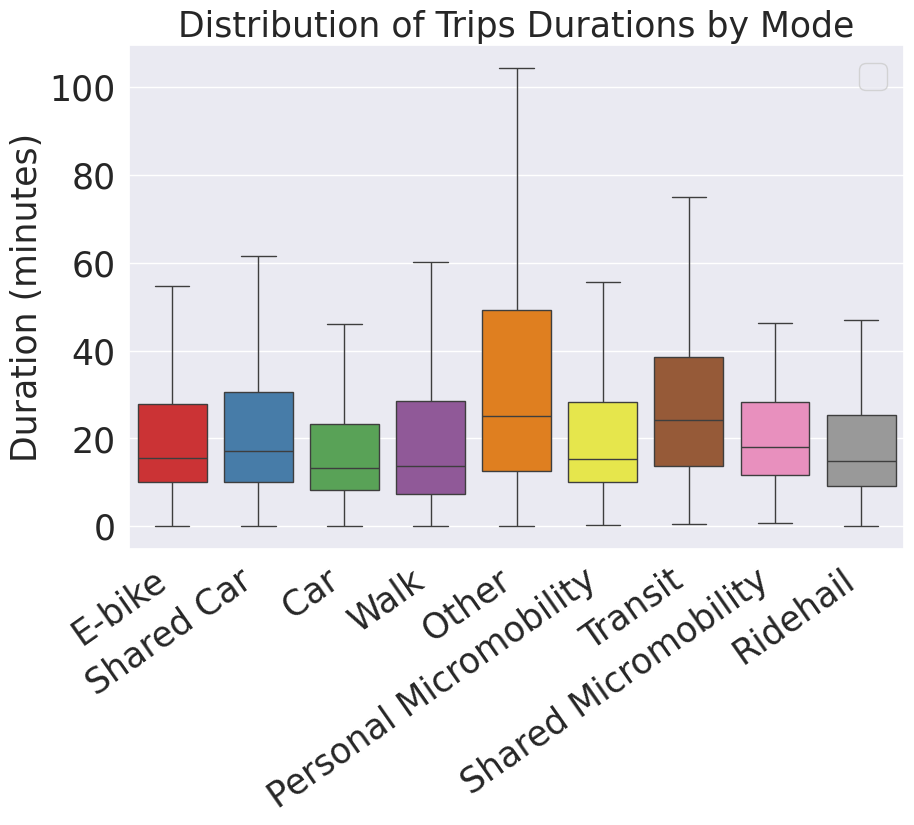

In [34]:
# Distribution of distances
make_distribution_plot(cleaned_data, 'duration', 'Distribution of Trips Durations by Mode', 'Duration (minutes)')

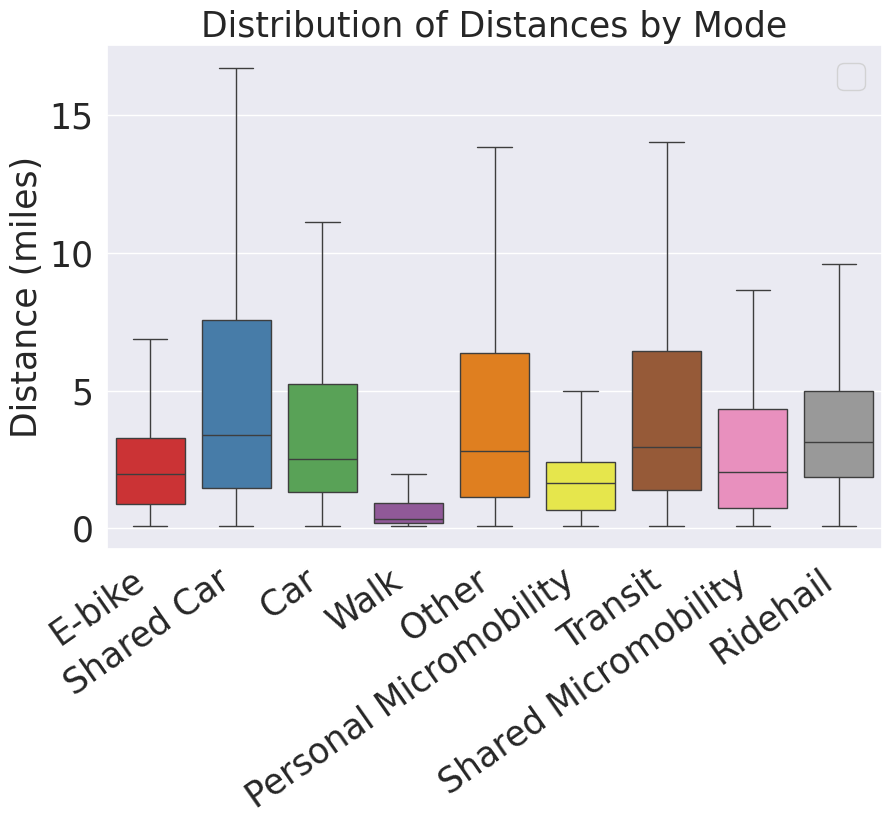

In [35]:
# Distribution of distances by program
make_distribution_plot(cleaned_data, 'distance_miles', 'Distribution of Distances by Mode', 'Distance (miles)')

### Proportion of trips that are ebike by income group

Figure #12

/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:249: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  t1['distance_miles'].fillna(0, inplace=True)
/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:258: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

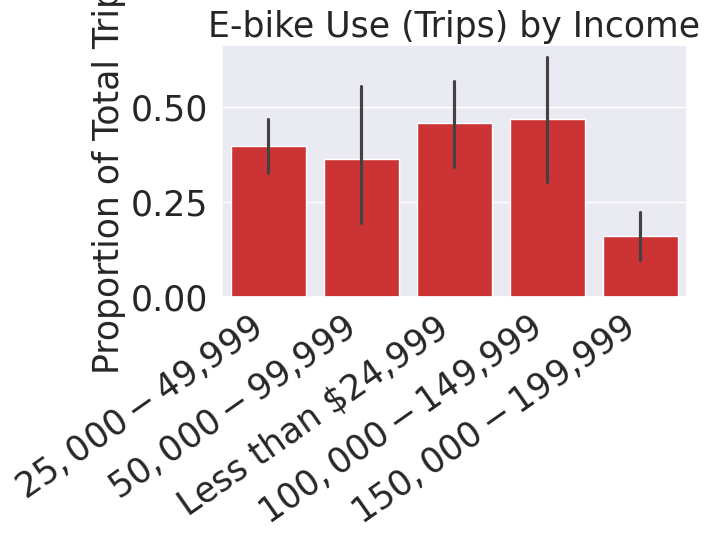

In [36]:
# Proportion of trips that are ebike by income group
make_ebike_proportion_chart(cleaned_data, True, 'HHINC', 'E-bike Use (Trips) by Income', 'Proportion of Total Trips', 'CanBikeCO_report_income_trips')

## Proportion of miles that are ebike by income group

figure #15

/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:249: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  t1['distance_miles'].fillna(0, inplace=True)
/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:258: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

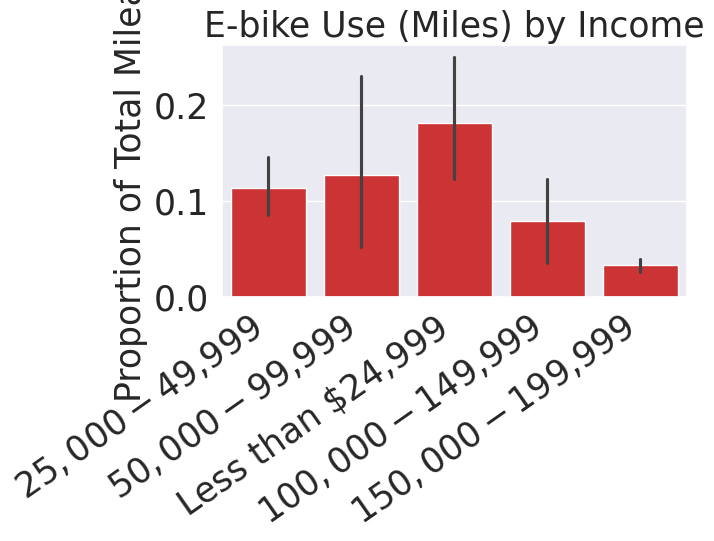

In [37]:
# Proportion of miles that are ebike by income group
make_ebike_proportion_chart(cleaned_data, False, 'HHINC', 'E-bike Use (Miles) by Income', 'Proportion of Total Mileage', 'CanBikeCO_report_income_mileages')

## Proportion of trips that are ebike by income group

figure #14

In [38]:
sns.set_palette('Paired', 5)

/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:249: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  t1['distance_miles'].fillna(0, inplace=True)
/usr/src/app/saved-notebooks/PaperVizualizations/Abby/paper_utilities.py:258: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

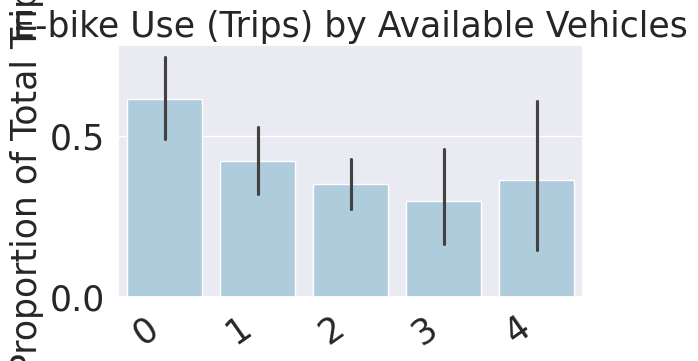

In [39]:
# Proportion of trips that are ebike by available vehicles
make_ebike_proportion_chart(cleaned_data, True, 'VEH_num', 'E-bike Use (Trips) by Available Vehicles', 'Proportion of Total Trips', 'CanBikeCO_report_veh_trips')

## mileage over time

figure #18 and #19

In [40]:
sns.set_palette('Set1', 3)

/tmp/ipykernel_2028/3130385133.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = plot_data.groupby(['User', 'Date']).distance_miles.sum().reset_index()


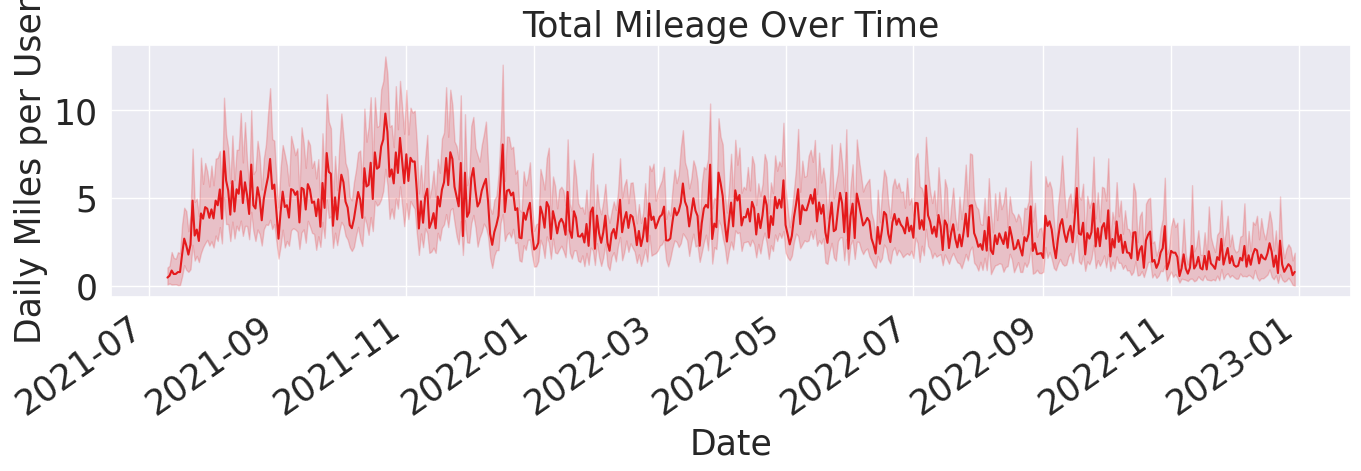

In [41]:
# How total mileage changes over time
plot_data = cleaned_data.copy()
plot_data ['date_time'] = pd.to_datetime(plot_data['date_time'])

#need to count all combinations - make sure to treat as categorical
plot_data["User"] = plot_data["user_id"].astype("category")
plot_data["Date"] = plot_data["date_time"].astype("category")
plot_data = plot_data.groupby(['User', 'Date']).distance_miles.sum().reset_index()

plot_data

plot_title = 'Total Mileage Over Time'
ylab = 'Daily Miles per User'
file_name = "CanBikeCO_report_ts_miles"
fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(data=plot_data, x='Date', y='distance_miles', estimator=np.mean).set(title=plot_title, xlabel='Date', ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".png", bbox_inches='tight')

/tmp/ipykernel_2028/1491160649.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t1 = plot_data.groupby(['user_id', 'date_time']).distance_miles.sum().reset_index()
/tmp/ipykernel_2028/1491160649.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t2 = plot_data.groupby(['user_id', 'date_time', 'Mode_confirm']).distance_miles.sum().reset_index()
/tmp/ipykernel_2028/1491160649.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermed

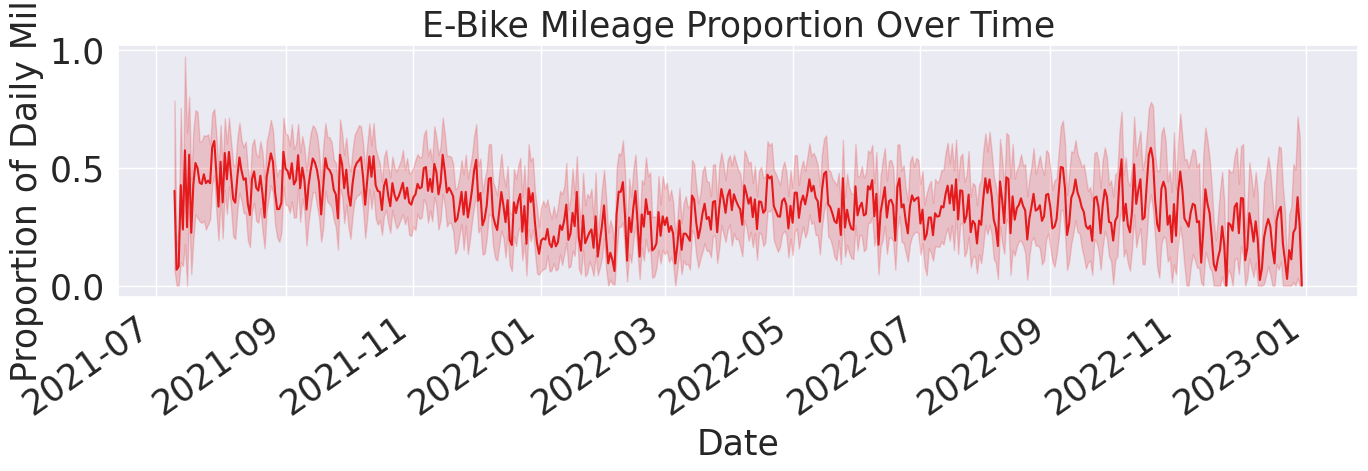

In [42]:
# How ebike mileage changes over time
plot_data = cleaned_data.copy()
plot_data['date_time'] = pd.to_datetime(plot_data['date_time'])

#treat as categorical to count all combinations
plot_data["user_id"] = plot_data["user_id"].astype("category")
plot_data["date_time"] = plot_data["date_time"].astype("category")
plot_data['Mode_confirm'] = plot_data['Mode_confirm'].astype("category")

#using the total mileage data as one side
t1 = plot_data.groupby(['user_id', 'date_time']).distance_miles.sum().reset_index()

#create the other side -- also grouping by mode
t2 = plot_data.groupby(['user_id', 'date_time', 'Mode_confirm']).distance_miles.sum().reset_index()

t2.sample(n=50, random_state=321)

#then we merge
plot_data = t2.merge(t1, on=['user_id','date_time'])
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data.sample(n=50, random_state=321)

plot_data['proportion'] = plot_data['distance_miles_x'] / plot_data['distance_miles_y']
plot_data['proportion'].fillna(0, inplace=True)

plot_data.sample(n=50, random_state=321)

plot_data = plot_data[plot_data['distance_miles_y'].notnull()]
plot_data = plot_data[plot_data['distance_miles_y'] != 0] #drop 0 mile days to prevent 0/0 reading as 1

plot_title = 'E-Bike Mileage Proportion Over Time'
ylab = 'Proportion of Daily Miles'
file_name = "CanBikeCO_report_ts_mileage_proportion"
fig, ax = plt.subplots(figsize=(16,4))
sns.lineplot(data=plot_data, x='date_time', y='proportion', estimator=np.mean).set(title=plot_title, xlabel='Date', ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
ax.figure.savefig(file_name+".png", bbox_inches='tight')

## Distance and mode!

figure #16 & 17

In [43]:
sns.set_palette('Set1', 9)

<Axes: xlabel='distance_miles', ylabel='Count'>

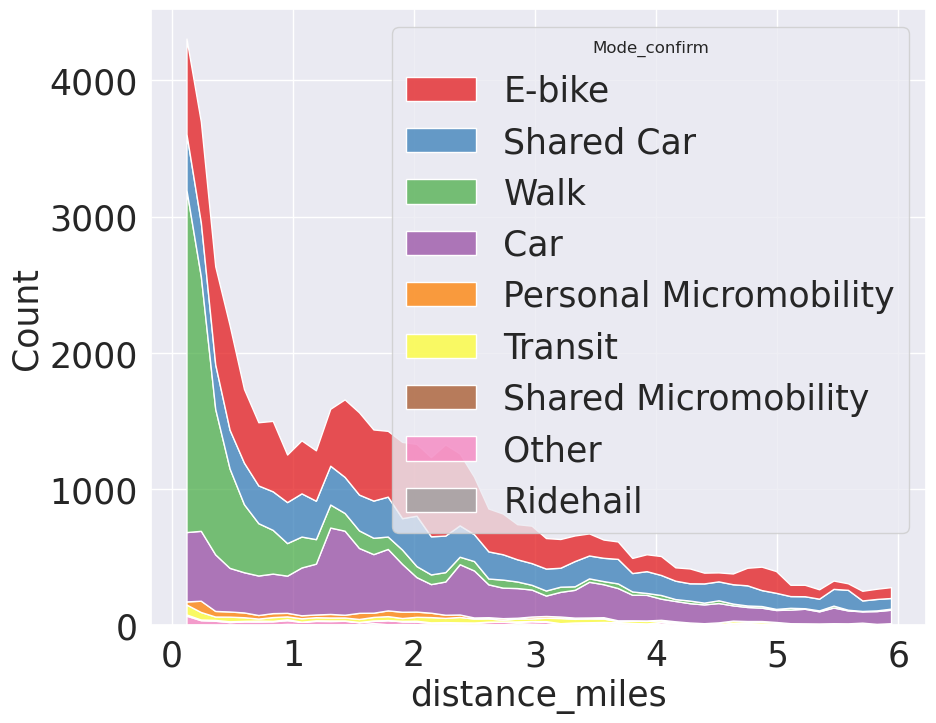

In [44]:
# Distance and mode chosen relationship -- short trips
plot_data = cleaned_data.copy()
plot_data = plot_data[plot_data['distance_miles']<6]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_short"
sns.histplot(plot_data, x="distance_miles", hue="Mode_confirm", element="poly", multiple="stack")

<Axes: xlabel='distance_miles', ylabel='Count'>

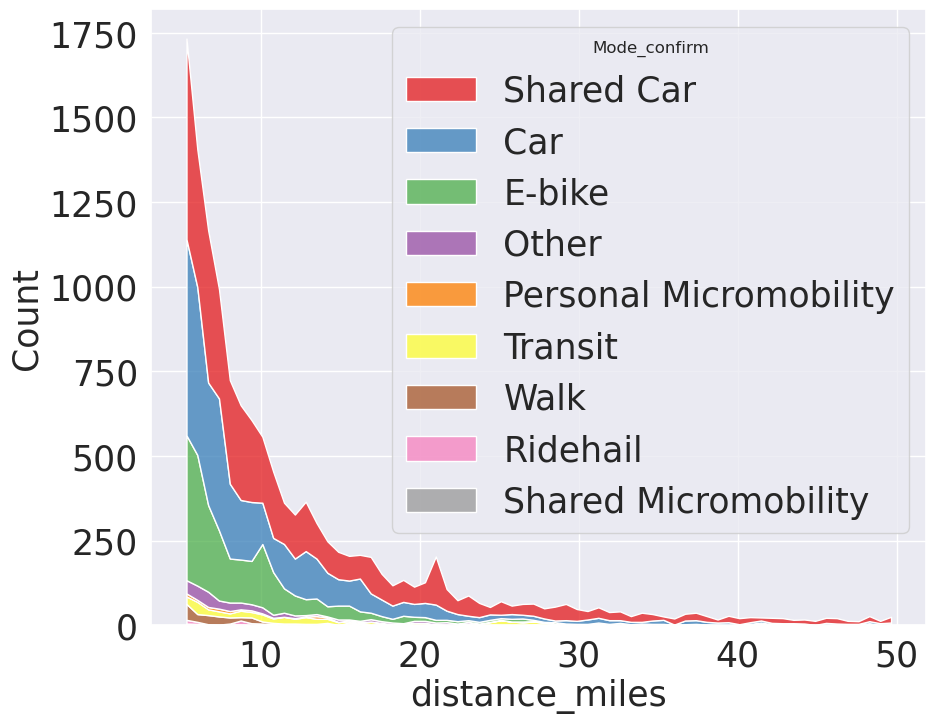

In [45]:
# Distance and mode chosen relationship -- long trips
plot_data = cleaned_data.copy()
plot_data = plot_data[plot_data['distance_miles']>5]

plot_title = 'Mode Share by Trip Distance'
ylab = 'Total Trips'
file_name = "CanBikeCO_report_mode_share_distance_long"
sns.histplot(plot_data, x="distance_miles", hue="Mode_confirm", element="poly", multiple="stack")

## induced trip purposes for e-bikes

Figure #24

/tmp/ipykernel_2028/473425058.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  t1['distance_miles'].fillna(0, inplace=True)
/tmp/ipykernel_2028/473425058.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

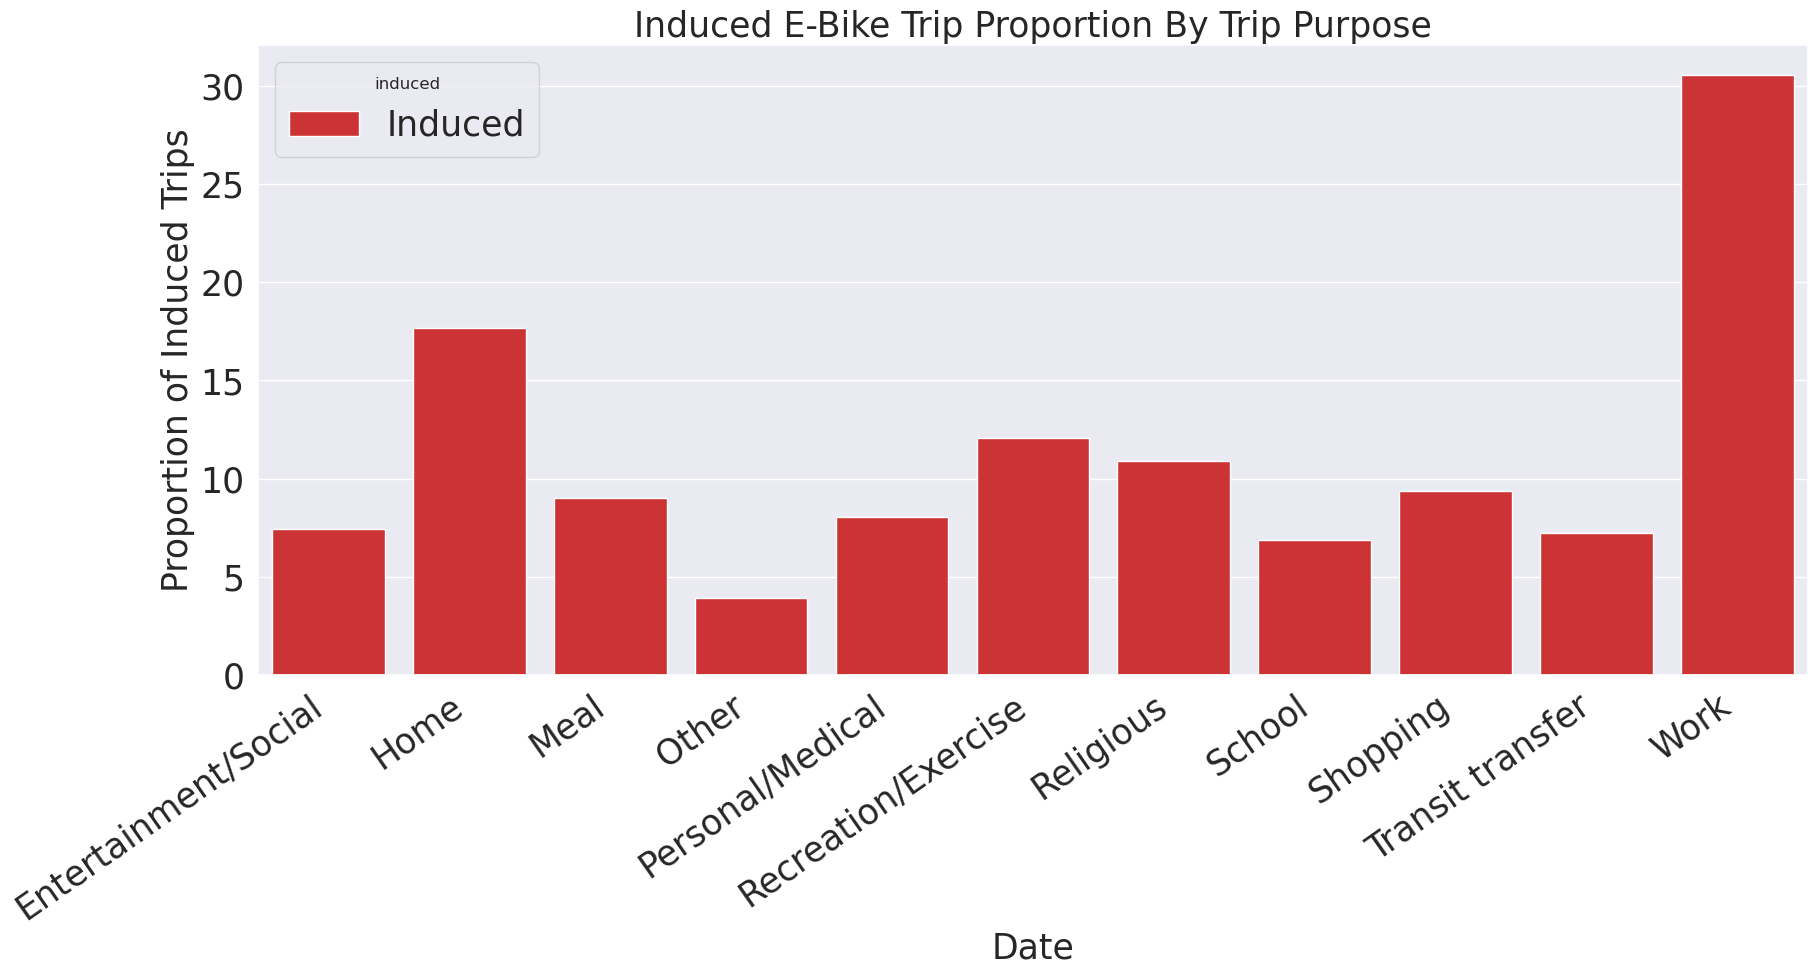

In [46]:
# What purpose ebike is used for by program
plot_data = data.copy()
# plot_data['induced']=np.where(plot_data['Replaced_mode']=='No Travel', 'Induced', 'Non-induced')
t1 = plot_data.groupby(['induced','Trip_purpose','Mode_confirm'], as_index=False).count()[['induced','Trip_purpose','Mode_confirm','distance_miles']]
t1['distance_miles'].fillna(0, inplace=True)
t2 = plot_data.groupby(['induced','Trip_purpose'], as_index=False).count()[['induced','Trip_purpose','distance_miles']]
plot_data = t1.merge(t2, on=['induced','Trip_purpose'])
plot_data['proportion'] = (plot_data['distance_miles_x'] / plot_data['distance_miles_y'])*100
plot_data['proportion'].fillna(0, inplace=True)
plot_data = plot_data[plot_data['Mode_confirm']=='E-bike']
plot_data = plot_data[plot_data['induced']=='Induced']

plot_title = 'Induced E-Bike Trip Proportion By Trip Purpose'
ylab = 'Proportion of Induced Trips'
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=plot_data, x='Trip_purpose', y='proportion', hue='induced',estimator=np.mean, ci=None).set(title=plot_title, xlabel='Date', ylabel=ylab)
plt.xticks(rotation=35, ha='right')
plt.subplots_adjust(bottom=0.25)
